## XGBoost with Mask Autoencoder 960-dimensional Embeddings + Hyperparameter Tuning

This notebook experiments with XGBoost using the 960-dimensional mask autoencoder embeddings with comprehensive hyperparameter tuning to maximize performance.

Key improvements:
- Uses 960-dim mask autoencoder embeddings
- Bayesian optimization for hyperparameter tuning
- Multiple feature combination strategies
- Cross-validation for robust evaluation
- Advanced XGBoost parameters

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pickle
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import gc
import xgboost as xgb
from scipy.stats import uniform, randint
import warnings
warnings.filterwarnings('ignore')

# Advanced optimization libraries
import optuna
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize

print("All advanced optimization libraries loaded successfully!")
print(f"Optuna version: {optuna.__version__}")
print("Scikit-optimize available")

/home/richard/miniconda3/envs/esm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All advanced optimization libraries loaded successfully!
Optuna version: 4.3.0
Scikit-optimize available


In [2]:
# First, let's examine the data structure to identify column names
def examine_dataframe(df):
    """Print the structure of the dataframe to identify column names"""
    print("DataFrame columns:", df.columns.tolist())
    print("First row sample:", df.iloc[0].to_dict())
    return df.columns.tolist()

# Get the absolute path of the current notebook
notebook_path = os.path.abspath('')

# Navigate to the project root (CS182-Final-Project)
project_root = os.path.dirname(notebook_path)
os.chdir(project_root)

print("Loading data...")
train_data = pickle.load(open('data/medium_set/train_data.pkl', 'rb'))
cv_data = pickle.load(open('data/medium_set/validation_data.pkl', 'rb'))
test1_data = pickle.load(open('data/medium_set/test1_data.pkl', 'rb'))
test2_data = pickle.load(open('data/medium_set/test2_data.pkl', 'rb'))

# Examine structure of the first dataframe to understand its format
print("\nExamining training data structure:")
examine_dataframe(train_data)

print("\nLoading Mask Autoencoder 960-dimensional protein embeddings...")
protein_embeddings = pickle.load(open('data/full_dataset/embeddings/compressed_protein_features.pkl', 'rb'))
print(f"Loaded {len(protein_embeddings)} protein embeddings")

print(train_data.head())
print("\nSample Mask Autoencoder embeddings:")
for i, (key, value) in enumerate(protein_embeddings.items()):
    if i >= 5:
        break
    print(f"Protein ID: {key}, Embedding shape: {value.shape}, Type: {type(value)}")

# Check class distribution
print(f"\nClass distribution in training data:")
print(train_data['isInteraction'].value_counts())
print(f"Class balance: {train_data['isInteraction'].value_counts(normalize=True)}")

Loading data...

Examining training data structure:
DataFrame columns: ['uniprotID_A', 'uniprotID_B', 'isInteraction', 'trainTest', 'sequence_A', 'sequence_B']
First row sample: {'uniprotID_A': 'Q92529', 'uniprotID_B': 'Q9H6L4', 'isInteraction': 0, 'trainTest': 'train', 'sequence_A': 'MLPRTKYNRFRNDSVTSVDDLLHSLSVSGGGGKVSAARATPAAAPYLVSGEALRKAPDDGPGSLGHLLHKVSHLKLSSSGLRGLSSAARERAGARLSGSCSAPSLAAPDGSAPSAPRAPAMSAARKGRPGDEPLPRPPRGAPHASDQVLGPGVTYVVKYLGCIEVLRSMRSLDFSTRTQITREAISRVCEAVPGAKGAFKKRKPPSKMLSSILGKSNLQFAGMSISLTISTASLNLRTPDSKQIIANHHMRSISFASGGDPDTTDYVAYVAKDPVNRRACHILECCDGLAQDVIGSIGQAFELRFKQYLQCPTKIPALHDRMQSLDEPWTEEEGDGSDHPYYNSIPSKMPPPGGFLDTRLKPRPHAPDTAQFAGKEQTYYQGRHLGDTFGEDWQQTPLRQGSSDIYSTPEGKLHVAPTGEAPTYVNTQQIPPQAWPAAVSSAESSPRKDLFDMKPFEDALKNQPLGPVLSKAASVECISPVSPRAPDAKMLEELQAETWYQGEMSRKEAEGLLEKDGDFLVRKSTTNPGSFVLTGMHNGQAKHLLLVDPEGTIRTKDRVFDSISHLINHHLESSLPIVSAGSELCLQQPVERKQ', 'sequence_B': 'MAQKPKVDPHVGRLGYLQALVTEFQETQSQDAKEQVLANLANFAYDPSNYEYLRQLQVLDLFLDSLSEENETLVEFAIGGLCNLCPDRANKEHILHAGGVPL

In [3]:
def extract_embeddings_separate(data_df, embeddings_dict, batch_size=100):
    """Extract separate mask autoencoder embeddings for protein A and B"""
    columns = data_df.columns.tolist()
    
    # Find column names
    protein_a_col = None
    protein_b_col = None
    interaction_col = None
    
    protein_a_patterns = ['protein_a', 'protein_id_a', 'proteinA', 'proteinIDA', 'protein_A', 'protein_id_A', 'uniprotID_A']
    protein_b_patterns = ['protein_b', 'protein_id_b', 'proteinB', 'proteinIDB', 'protein_B', 'protein_id_B', 'uniprotID_B']
    interaction_patterns = ['isInteraction', 'is_interaction', 'interaction', 'label']
    
    for col in columns:
        col_lower = col.lower()
        if any(pattern.lower() in col_lower for pattern in protein_a_patterns):
            protein_a_col = col
        elif any(pattern.lower() in col_lower for pattern in protein_b_patterns):
            protein_b_col = col
        elif any(pattern.lower() in col_lower for pattern in interaction_patterns):
            interaction_col = col
    
    if protein_a_col is None or protein_b_col is None:
        first_row = data_df.iloc[0].to_dict()
        for col, val in first_row.items():
            if isinstance(val, str) and val in embeddings_dict:
                if protein_a_col is None:
                    protein_a_col = col
                elif protein_b_col is None and col != protein_a_col:
                    protein_b_col = col
    
    print(f"Using columns: Protein A = '{protein_a_col}', Protein B = '{protein_b_col}', Interaction = '{interaction_col}'")
    
    embA_list = []
    embB_list = []
    y_list = []
    skipped = 0
    
    for i in tqdm(range(0, len(data_df), batch_size), desc="Extracting MaskAE embeddings"):
        batch = data_df.iloc[i:i+batch_size]
        
        for _, row in batch.iterrows():
            protein_A = row[protein_a_col]
            protein_B = row[protein_b_col]
            
            if protein_A not in embeddings_dict or protein_B not in embeddings_dict:
                skipped += 1
                continue
            
            # Mask autoencoder embeddings are already 960-dimensional vectors
            embedding_A = embeddings_dict[protein_A]
            embedding_B = embeddings_dict[protein_B]
            
            # Convert to numpy if needed
            if isinstance(embedding_A, torch.Tensor):
                feat_A = embedding_A.cpu().numpy()
                feat_B = embedding_B.cpu().numpy()
            else:
                feat_A = embedding_A
                feat_B = embedding_B
            
            embA_list.append(feat_A)
            embB_list.append(feat_B)
            y_list.append(row[interaction_col])
    
    print(f"Processed {len(embA_list)} protein pairs. Skipped {skipped} pairs.")
    return np.array(embA_list), np.array(embB_list), np.array(y_list)

def create_features(embA, embB, method='all'):
    """Create combined features from protein embeddings with enhanced methods"""
    if method == 'all':
        # Most comprehensive feature set
        return np.concatenate([embA, embB, np.abs(embA - embB), embA * embB], axis=1)
    elif method == 'concatenate':
        return np.concatenate([embA, embB], axis=1)
    elif method == 'add_sub':
        return np.concatenate([embA + embB, embA - embB], axis=1)
    elif method == 'mul_only':
        return embA * embB
    elif method == 'abs_diff':
        return np.abs(embA - embB)
    elif method == 'enhanced':
        # New enhanced method with more sophisticated combinations
        sum_feat = embA + embB
        diff_feat = embA - embB
        abs_diff_feat = np.abs(embA - embB)
        mul_feat = embA * embB
        max_feat = np.maximum(embA, embB)
        min_feat = np.minimum(embA, embB)
        return np.concatenate([embA, embB, sum_feat, abs_diff_feat, mul_feat, max_feat, min_feat], axis=1)
    elif method == 'statistical':
        # Statistical features
        sum_feat = embA + embB
        diff_feat = embA - embB
        mul_feat = embA * embB
        mean_feat = (embA + embB) / 2
        return np.concatenate([sum_feat, diff_feat, mul_feat, mean_feat], axis=1)
    else:
        raise ValueError(f"Unknown method: {method}")

# Extract separate embeddings for all datasets
print("Extracting separate Mask Autoencoder embeddings...")
train_embA, train_embB, train_y = extract_embeddings_separate(train_data, protein_embeddings)
val_embA, val_embB, val_y = extract_embeddings_separate(cv_data, protein_embeddings)
test1_embA, test1_embB, test1_y = extract_embeddings_separate(test1_data, protein_embeddings)
test2_embA, test2_embB, test2_y = extract_embeddings_separate(test2_data, protein_embeddings)

print(f"Train embeddings: A={train_embA.shape}, B={train_embB.shape}, y={train_y.shape}")
print(f"Val embeddings: A={val_embA.shape}, B={val_embB.shape}, y={val_y.shape}")
print(f"Test1 embeddings: A={test1_embA.shape}, B={test1_embB.shape}, y={test1_y.shape}")
print(f"Test2 embeddings: A={test2_embA.shape}, B={test2_embB.shape}, y={test2_y.shape}")

Extracting separate Mask Autoencoder embeddings...
Using columns: Protein A = 'uniprotID_A', Protein B = 'uniprotID_B', Interaction = 'isInteraction'


Extracting MaskAE embeddings: 100%|██████████| 100/100 [00:00<00:00, 386.45it/s]


Processed 10000 protein pairs. Skipped 0 pairs.
Using columns: Protein A = 'uniprotID_A', Protein B = 'uniprotID_B', Interaction = 'isInteraction'


Extracting MaskAE embeddings: 100%|██████████| 20/20 [00:00<00:00, 410.12it/s]


Processed 2000 protein pairs. Skipped 0 pairs.
Using columns: Protein A = 'uniprotID_A', Protein B = 'uniprotID_B', Interaction = 'isInteraction'


Extracting MaskAE embeddings: 100%|██████████| 20/20 [00:00<00:00, 386.69it/s]


Processed 2000 protein pairs. Skipped 0 pairs.
Using columns: Protein A = 'uniprotID_A', Protein B = 'uniprotID_B', Interaction = 'isInteraction'


Extracting MaskAE embeddings: 100%|██████████| 100/100 [00:00<00:00, 414.87it/s]

Processed 10000 protein pairs. Skipped 0 pairs.
Train embeddings: A=(10000, 960), B=(10000, 960), y=(10000,)
Val embeddings: A=(2000, 960), B=(2000, 960), y=(2000,)
Test1 embeddings: A=(2000, 960), B=(2000, 960), y=(2000,)
Test2 embeddings: A=(10000, 960), B=(10000, 960), y=(10000,)


In [4]:
class AdvancedXGBoostTuner:
    """Advanced XGBoost hyperparameter tuning with compatibility fixes"""
    
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.best_params = None
        self.best_score = 0
        self.best_model = None
        self.optimization_history = {}
        
    def get_param_space_optuna(self):
        """Define parameter space for Optuna optimization"""
        return {
            'n_estimators': (50, 300),
            'learning_rate': (0.01, 0.3),
            'max_depth': (3, 10),
            'min_child_weight': (1, 10),
            'subsample': (0.6, 1.0),
            'colsample_bytree': (0.6, 1.0),
            'gamma': (0, 5),
            'reg_alpha': (0, 10),
            'reg_lambda': (1, 10),
        }
    
    def manual_cross_validation(self, model, X, y, cv_folds=3):
        """Manual cross-validation to avoid sklearn compatibility issues"""
        from sklearn.model_selection import StratifiedKFold
        from sklearn.metrics import f1_score
        
        cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=self.random_state)
        scores = []
        
        for train_idx, val_idx in cv.split(X, y):
            X_train_fold, X_val_fold = X[train_idx], X[val_idx]
            y_train_fold, y_val_fold = y[train_idx], y[val_idx]
            
            # Clone the model to avoid fitting issues
            fold_model = xgb.XGBClassifier(**model.get_params())
            fold_model.fit(X_train_fold, y_train_fold)
            
            y_pred = fold_model.predict(X_val_fold)
            score = f1_score(y_val_fold, y_pred)
            scores.append(score)
        
        return np.array(scores)
    
    def optuna_objective(self, trial, X_train, y_train, cv_folds=3):
        """Optuna objective function with manual CV"""
        param_space = self.get_param_space_optuna()
        
        params = {
            'n_estimators': trial.suggest_int('n_estimators', *param_space['n_estimators']),
            'learning_rate': trial.suggest_float('learning_rate', *param_space['learning_rate'], log=True),
            'max_depth': trial.suggest_int('max_depth', *param_space['max_depth']),
            'min_child_weight': trial.suggest_int('min_child_weight', *param_space['min_child_weight']),
            'subsample': trial.suggest_float('subsample', *param_space['subsample']),
            'colsample_bytree': trial.suggest_float('colsample_bytree', *param_space['colsample_bytree']),
            'gamma': trial.suggest_float('gamma', *param_space['gamma']),
            'reg_alpha': trial.suggest_float('reg_alpha', *param_space['reg_alpha']),
            'reg_lambda': trial.suggest_float('reg_lambda', *param_space['reg_lambda']),
            'tree_method': 'hist',
            'random_state': self.random_state,
            'eval_metric': 'logloss',
            'n_jobs': 1,  # Single thread to avoid issues
            'verbosity': 0  # Suppress warnings
        }
        
        # Create model
        model = xgb.XGBClassifier(**params)
        
        # Manual cross-validation
        cv_scores = self.manual_cross_validation(model, X_train, y_train, cv_folds)
        
        return cv_scores.mean()
    
    def tune_with_optuna(self, X_train, y_train, X_val, y_val, n_trials=50, cv_folds=3):
        """Tune hyperparameters using Optuna with manual CV"""
        print(f"Starting Optuna optimization with {n_trials} trials...")
        
        study = optuna.create_study(
            direction='maximize',
            sampler=optuna.samplers.TPESampler(seed=self.random_state),
            pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=3)
        )
        
        objective_with_data = lambda trial: self.optuna_objective(trial, X_train, y_train, cv_folds)
        
        study.optimize(objective_with_data, n_trials=n_trials, show_progress_bar=True)
        
        # Get best parameters and train final model
        best_params = study.best_params
        best_params.update({
            'tree_method': 'hist',
            'random_state': self.random_state,
            'eval_metric': 'logloss',
            'n_jobs': 1,
            'verbosity': 0
        })
        
        best_model = xgb.XGBClassifier(**best_params)
        best_model.fit(X_train, y_train)
        
        # Evaluate on validation set
        val_preds = best_model.predict(X_val)
        val_proba = best_model.predict_proba(X_val)[:, 1]
        val_score = f1_score(y_val, val_preds)
        
        self.optimization_history['optuna'] = {
            'study': study,
            'best_params': best_params,
            'best_score': val_score,
            'best_model': best_model
        }
        
        return best_model, best_params, val_score, study
    
    def tune_with_grid_search(self, X_train, y_train, X_val, y_val, cv_folds=3):
        """Simple grid search as fallback"""
        print("Starting grid search optimization...")
        
        param_grid = {
            'n_estimators': [50, 100, 150],
            'learning_rate': [0.05, 0.1, 0.15],
            'max_depth': [4, 6, 8],
            'min_child_weight': [1, 3, 5],
            'subsample': [0.8, 0.9],
            'colsample_bytree': [0.8, 0.9],
        }
        
        best_score = 0
        best_params = None
        best_model = None
        
        # Simple grid search
        from itertools import product
        
        param_combinations = []
        keys = list(param_grid.keys())
        values = list(param_grid.values())
        
        for combination in product(*values):
            param_dict = dict(zip(keys, combination))
            param_combinations.append(param_dict)
        
        print(f"Testing {len(param_combinations)} parameter combinations...")
        
        for i, params in enumerate(tqdm(param_combinations[:20], desc="Grid search")):  # Limit to 20 combinations
            params.update({
                'tree_method': 'hist',
                'random_state': self.random_state,
                'eval_metric': 'logloss',
                'n_jobs': 1,
                'verbosity': 0
            })
            
            try:
                model = xgb.XGBClassifier(**params)
                cv_scores = self.manual_cross_validation(model, X_train, y_train, cv_folds)
                avg_score = cv_scores.mean()
                
                if avg_score > best_score:
                    best_score = avg_score
                    best_params = params.copy()
                    
                    # Train final model
                    best_model = xgb.XGBClassifier(**params)
                    best_model.fit(X_train, y_train)
                    
            except Exception as e:
                print(f"Error with params {params}: {e}")
                continue
        
        if best_model is not None:
            # Evaluate on validation set
            val_preds = best_model.predict(X_val)
            val_score = f1_score(y_val, val_preds)
            
            self.optimization_history['grid'] = {
                'best_params': best_params,
                'best_score': val_score,
                'best_model': best_model
            }
            
            return best_model, best_params, val_score, None
        else:
            raise Exception("Grid search failed to find any working parameters")
    
    def ensemble_optimization(self, X_train, y_train, X_val, y_val, methods=['optuna'], 
                            n_trials_optuna=30, cv_folds=3):
        """Run optimization methods with fallbacks"""
        print("Starting ensemble optimization...")
        
        results = {}
        
        if 'optuna' in methods:
            try:
                model, params, score, study = self.tune_with_optuna(
                    X_train, y_train, X_val, y_val, n_trials_optuna, cv_folds
                )
                results['optuna'] = {'model': model, 'params': params, 'score': score, 'study': study}
                print(f"Optuna F1 Score: {score:.4f}")
            except Exception as e:
                print(f"Optuna failed: {e}")
                print("Falling back to grid search...")
                
                try:
                    model, params, score, _ = self.tune_with_grid_search(
                        X_train, y_train, X_val, y_val, cv_folds
                    )
                    results['grid'] = {'model': model, 'params': params, 'score': score}
                    print(f"Grid Search F1 Score: {score:.4f}")
                except Exception as e2:
                    print(f"Grid search also failed: {e2}")
                    
                    # Final fallback: simple default parameters
                    print("Using default parameters as final fallback...")
                    default_params = {
                        'n_estimators': 100,
                        'learning_rate': 0.1,
                        'max_depth': 6,
                        'min_child_weight': 3,
                        'subsample': 0.8,
                        'colsample_bytree': 0.8,
                        'tree_method': 'hist',
                        'random_state': self.random_state,
                        'eval_metric': 'logloss',
                        'n_jobs': 1,
                        'verbosity': 0
                    }
                    
                    model = xgb.XGBClassifier(**default_params)
                    model.fit(X_train, y_train)
                    val_preds = model.predict(X_val)
                    score = f1_score(y_val, val_preds)
                    
                    results['default'] = {'model': model, 'params': default_params, 'score': score}
                    print(f"Default Parameters F1 Score: {score:.4f}")
        
        # Find best method
        if results:
            best_method = max(results.keys(), key=lambda k: results[k]['score'])
            best_result = results[best_method]
            
            print(f"\nBest optimization method: {best_method}")
            print(f"Best F1 Score: {best_result['score']:.4f}")
            
            self.best_model = best_result['model']
            self.best_params = best_result['params']
            self.best_score = best_result['score']
            
            return best_result['model'], best_result['params'], best_result['score'], results
        else:
            raise Exception("All optimization methods failed!")

# Initialize the advanced tuner
tuner = AdvancedXGBoostTuner(random_state=42)
print("Compatible Advanced XGBoost tuner initialized!")

Compatible Advanced XGBoost tuner initialized!


In [5]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score

# Test different feature combination methods with compatible hyperparameter tuning
methods = ['concatenate', 'mul_only', 'abs_diff']  # Start with simpler methods
optimization_strategies = ['optuna']  # Use only Optuna for now

best_overall_score = 0
best_overall_model = None
best_overall_method = None
best_overall_scaler = None
best_overall_params = None
best_overall_strategy = None

results = {}
failed_methods = []

for method in methods:
    print(f"\n{'='*80}")
    print(f"TESTING METHOD: {method.upper()}")
    print(f"{'='*80}")
    
    try:
        # Create features using the specified method
        X_train = create_features(train_embA, train_embB, method=method)
        X_val = create_features(val_embA, val_embB, method=method)
        X_test1 = create_features(test1_embA, test1_embB, method=method)
        X_test2 = create_features(test2_embA, test2_embB, method=method)

        print(f"Feature shapes - Train: {X_train.shape}, Val: {X_val.shape}")
        
        # Try both StandardScaler and RobustScaler
        scalers = {'standard': StandardScaler(), 'robust': RobustScaler()}
        best_scaler_type = None
        best_scaler_score = 0
        best_scaler_obj = None
        best_method_model = None
        best_method_params = None
        best_method_strategy = None
        method_failed = True
        
        for scaler_name, scaler in scalers.items():
            print(f"\n{'-'*50}")
            print(f"Testing with {scaler_name} scaler")
            print(f"{'-'*50}")
            
            try:
                # Scale features
                X_train_scaled = scaler.fit_transform(X_train)
                X_val_scaled = scaler.transform(X_val)
                X_test1_scaled = scaler.transform(X_test1)
                X_test2_scaled = scaler.transform(X_test2)
                
                print(f"Features scaled. Shape: {X_train_scaled.shape}")
                
                # Advanced hyperparameter tuning
                tuner_instance = AdvancedXGBoostTuner(random_state=42)
                
                # Run optimization
                best_model, best_params, best_score, optimization_results = tuner_instance.ensemble_optimization(
                    X_train_scaled, train_y, X_val_scaled, val_y,
                    methods=optimization_strategies,
                    n_trials_optuna=20,  # Reduced for faster execution
                    cv_folds=3
                )
                
                print(f"\nOptimization completed for {method} with {scaler_name} scaler")
                print(f"Best F1 Score: {best_score:.4f}")
                
                # Get detailed metrics
                val_preds = best_model.predict(X_val_scaled)
                val_proba = best_model.predict_proba(X_val_scaled)[:, 1]
                
                detailed_metrics = {
                    'accuracy': accuracy_score(val_y, val_preds),
                    'f1': f1_score(val_y, val_preds),
                    'auc': roc_auc_score(val_y, val_proba),
                    'precision': precision_score(val_y, val_preds),
                    'recall': recall_score(val_y, val_preds)
                }
                
                print("Detailed validation metrics:")
                for metric, value in detailed_metrics.items():
                    print(f"  {metric}: {value:.4f}")
                
                # Check if this is the best scaler for this method
                if best_score > best_scaler_score:
                    best_scaler_score = best_score
                    best_scaler_type = scaler_name
                    best_scaler_obj = scaler
                    best_method_model = best_model
                    best_method_params = best_params
                    best_method_strategy = list(optimization_results.keys())[0]  # First successful method
                    method_failed = False
                    
                    # Store scaled data for later use
                    method_X_train_scaled = X_train_scaled
                    method_X_val_scaled = X_val_scaled
                    method_X_test1_scaled = X_test1_scaled
                    method_X_test2_scaled = X_test2_scaled
                    method_detailed_metrics = detailed_metrics
                    method_optimization_results = optimization_results
                    
            except Exception as e:
                print(f"✗ Error with {scaler_name} scaler for {method}: {e}")
                continue
        
        if not method_failed and best_method_model is not None:
            # Store results for this method
            results[method] = {
                'model': best_method_model,
                'scaler': best_scaler_obj,
                'scaler_type': best_scaler_type,
                'best_params': best_method_params,
                'optimization_strategy': best_method_strategy,
                'optimization_results': method_optimization_results,
                'X_train_scaled': method_X_train_scaled,
                'X_val_scaled': method_X_val_scaled,
                'X_test1_scaled': method_X_test1_scaled,
                'X_test2_scaled': method_X_test2_scaled
            }
            
            # Add detailed metrics
            results[method].update(method_detailed_metrics)
            
            print(f"\n✓ SUCCESS: Best configuration for {method}:")
            print(f"  Scaler: {best_scaler_type}")
            print(f"  Optimization Strategy: {best_method_strategy}")
            print(f"  F1 Score: {best_scaler_score:.4f}")
            print(f"  Accuracy: {method_detailed_metrics['accuracy']:.4f}")
            print(f"  AUC: {method_detailed_metrics['auc']:.4f}")
            
            # Check if this is the overall best
            if best_scaler_score > best_overall_score:
                best_overall_score = best_scaler_score
                best_overall_model = best_method_model
                best_overall_method = method
                best_overall_scaler = best_scaler_obj
                best_overall_params = best_method_params
                best_overall_strategy = best_method_strategy
        else:
            print(f"✗ FAILED: Method {method} failed with all scalers")
            failed_methods.append(method)
            
    except Exception as e:
        print(f"✗ FAILED: Method {method} failed completely: {e}")
        failed_methods.append(method)
        continue

print(f"\n{'='*100}")
print("COMPATIBLE ADVANCED OPTIMIZATION SUMMARY")
print(f"{'='*100}")
print(f"Successful methods: {len(results)}")
print(f"Failed methods: {len(failed_methods)}")
if failed_methods:
    print(f"Failed method list: {failed_methods}")

if results:
    print(f"\nOVERALL BEST CONFIGURATION:")
    print(f"  Method: {best_overall_method}")
    print(f"  Scaler: {results[best_overall_method]['scaler_type']}")
    print(f"  Optimization Strategy: {best_overall_strategy}")
    print(f"  F1 Score: {best_overall_score:.4f}")
    print(f"  Accuracy: {results[best_overall_method]['accuracy']:.4f}")
    print(f"  AUC: {results[best_overall_method]['auc']:.4f}")
    
    print(f"\nBest hyperparameters:")
    for param, value in best_overall_params.items():
        if param not in ['tree_method', 'random_state', 'eval_metric', 'n_jobs', 'verbosity']:
            print(f"  {param}: {value}")
else:
    print("\n⚠️  WARNING: No methods succeeded!")
    print("Consider using simpler approaches or checking data integrity.")

print(f"{'='*100}")


TESTING METHOD: CONCATENATE
Feature shapes - Train: (10000, 1920), Val: (2000, 1920)

--------------------------------------------------
Testing with standard scaler
--------------------------------------------------


[I 2025-05-26 18:30:59,968] A new study created in memory with name: no-name-1042b2e3-4dbf-4b37-af0f-0649303d8a7d


Features scaled. Shape: (10000, 1920)
Starting ensemble optimization...
Starting Optuna optimization with 20 trials...


Best trial: 0. Best value: 0.562445:   5%|▌         | 1/20 [01:47<34:01, 107.44s/it]

[I 2025-05-26 18:32:47,410] Trial 0 finished with value: 0.5624445416803483 and parameters: {'n_estimators': 144, 'learning_rate': 0.2536999076681772, 'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'gamma': 0.2904180608409973, 'reg_alpha': 8.661761457749352, 'reg_lambda': 6.41003510568888}. Best is trial 0 with value: 0.5624445416803483.


Best trial: 0. Best value: 0.562445:  10%|█         | 2/20 [06:28<1:02:50, 209.48s/it]

[I 2025-05-26 18:37:28,311] Trial 1 finished with value: 0.5611580244701353 and parameters: {'n_estimators': 227, 'learning_rate': 0.010725209743171997, 'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'gamma': 0.9170225492671691, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.72280788469014}. Best is trial 0 with value: 0.5624445416803483.


Best trial: 0. Best value: 0.562445:  15%|█▌        | 3/20 [09:02<52:11, 184.19s/it]  

[I 2025-05-26 18:40:02,420] Trial 2 finished with value: 0.561844755487092 and parameters: {'n_estimators': 158, 'learning_rate': 0.02692655251486473, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.7168578594140873, 'colsample_bytree': 0.7465447373174767, 'gamma': 2.28034992108518, 'reg_alpha': 7.851759613930136, 'reg_lambda': 2.7970640394252375}. Best is trial 0 with value: 0.5624445416803483.


Best trial: 0. Best value: 0.562445:  20%|██        | 4/20 [09:32<32:54, 123.42s/it]

[I 2025-05-26 18:40:32,681] Trial 3 finished with value: 0.5499294170854363 and parameters: {'n_estimators': 179, 'learning_rate': 0.07500118950416987, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.6682096494749166, 'colsample_bytree': 0.6260206371941118, 'gamma': 4.7444276862666666, 'reg_alpha': 9.656320330745594, 'reg_lambda': 8.275576133048151}. Best is trial 0 with value: 0.5624445416803483.


Best trial: 4. Best value: 0.563818:  25%|██▌       | 5/20 [12:25<35:16, 141.12s/it]

[I 2025-05-26 18:43:25,187] Trial 4 finished with value: 0.5638184662110891 and parameters: {'n_estimators': 126, 'learning_rate': 0.013940346079873234, 'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.6488152939379115, 'colsample_bytree': 0.798070764044508, 'gamma': 0.17194260557609198, 'reg_alpha': 9.093204020787821, 'reg_lambda': 3.3290198344001523}. Best is trial 4 with value: 0.5638184662110891.


Best trial: 4. Best value: 0.563818:  30%|███       | 6/20 [14:48<33:05, 141.80s/it]

[I 2025-05-26 18:45:48,287] Trial 5 finished with value: 0.5565710976246632 and parameters: {'n_estimators': 216, 'learning_rate': 0.028869220380495747, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.6739417822102108, 'colsample_bytree': 0.9878338511058234, 'gamma': 3.8756641168055728, 'reg_alpha': 9.394989415641891, 'reg_lambda': 9.053446153848839}. Best is trial 4 with value: 0.5638184662110891.


Best trial: 4. Best value: 0.563818:  35%|███▌      | 7/20 [15:27<23:26, 108.22s/it]

[I 2025-05-26 18:46:27,392] Trial 6 finished with value: 0.5497235012276932 and parameters: {'n_estimators': 200, 'learning_rate': 0.22999586428143728, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.6180909155642152, 'colsample_bytree': 0.7301321323053057, 'gamma': 1.9433864484474102, 'reg_alpha': 2.713490317738959, 'reg_lambda': 8.458637582367365}. Best is trial 4 with value: 0.5638184662110891.


Best trial: 4. Best value: 0.563818:  40%|████      | 8/20 [16:36<19:08, 95.68s/it] 

[I 2025-05-26 18:47:36,225] Trial 7 finished with value: 0.558905785326126 and parameters: {'n_estimators': 139, 'learning_rate': 0.026000059117302653, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.9208787923016158, 'colsample_bytree': 0.6298202574719083, 'gamma': 4.9344346830025865, 'reg_alpha': 7.722447692966574, 'reg_lambda': 2.7884411338075514}. Best is trial 4 with value: 0.5638184662110891.


Best trial: 4. Best value: 0.563818:  45%|████▌     | 9/20 [17:28<15:01, 81.95s/it]

[I 2025-05-26 18:48:27,973] Trial 8 finished with value: 0.552451644016929 and parameters: {'n_estimators': 51, 'learning_rate': 0.1601531217136121, 'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.9085081386743783, 'colsample_bytree': 0.6296178606936361, 'gamma': 1.7923286427213632, 'reg_alpha': 1.1586905952512971, 'reg_lambda': 8.767930832880342}. Best is trial 4 with value: 0.5638184662110891.


Best trial: 4. Best value: 0.563818:  50%|█████     | 10/20 [18:10<11:38, 69.84s/it]

[I 2025-05-26 18:49:10,697] Trial 9 finished with value: 0.5498280334620701 and parameters: {'n_estimators': 206, 'learning_rate': 0.030816017044468066, 'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.7300733288106989, 'colsample_bytree': 0.8918424713352255, 'gamma': 3.1877873567760657, 'reg_alpha': 8.872127425763265, 'reg_lambda': 5.249934326457543}. Best is trial 4 with value: 0.5638184662110891.


Best trial: 4. Best value: 0.563818:  55%|█████▌    | 11/20 [20:40<14:09, 94.44s/it]

[I 2025-05-26 18:51:40,907] Trial 10 finished with value: 0.5593452540360957 and parameters: {'n_estimators': 287, 'learning_rate': 0.010206070557576998, 'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.8144754354791038, 'colsample_bytree': 0.8429521169792498, 'gamma': 0.07563407956692297, 'reg_alpha': 6.135622195040732, 'reg_lambda': 1.4265319195227373}. Best is trial 4 with value: 0.5638184662110891.


Best trial: 4. Best value: 0.563818:  60%|██████    | 12/20 [23:37<15:56, 119.54s/it]

[I 2025-05-26 18:54:37,859] Trial 11 finished with value: 0.5609573928230538 and parameters: {'n_estimators': 104, 'learning_rate': 0.08485834338701036, 'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.7898925643930462, 'colsample_bytree': 0.7890856026631795, 'gamma': 0.05866078603456101, 'reg_alpha': 6.071842740332256, 'reg_lambda': 5.819232957285262}. Best is trial 4 with value: 0.5638184662110891.


Best trial: 4. Best value: 0.563818:  65%|██████▌   | 13/20 [25:17<13:14, 113.56s/it]

[I 2025-05-26 18:56:17,670] Trial 12 finished with value: 0.5578669527394271 and parameters: {'n_estimators': 105, 'learning_rate': 0.13111127857406177, 'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.6109470798815742, 'colsample_bytree': 0.9082265840801372, 'gamma': 1.0414013305441188, 'reg_alpha': 7.299436732862953, 'reg_lambda': 4.085726556080028}. Best is trial 4 with value: 0.5638184662110891.


Best trial: 4. Best value: 0.563818:  70%|███████   | 14/20 [26:25<09:58, 99.69s/it] 

[I 2025-05-26 18:57:25,318] Trial 13 finished with value: 0.5535925194102497 and parameters: {'n_estimators': 110, 'learning_rate': 0.28194136525387814, 'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.7667698433310003, 'colsample_bytree': 0.7155509247778411, 'gamma': 0.9795961621027555, 'reg_alpha': 4.339982574915247, 'reg_lambda': 6.912801399040424}. Best is trial 4 with value: 0.5638184662110891.


Best trial: 4. Best value: 0.563818:  75%|███████▌  | 15/20 [28:01<08:12, 98.55s/it]

[I 2025-05-26 18:59:01,201] Trial 14 finished with value: 0.5559349609008096 and parameters: {'n_estimators': 53, 'learning_rate': 0.052689656190800044, 'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.852433737415586, 'colsample_bytree': 0.8124496121405842, 'gamma': 0.4930286605810518, 'reg_alpha': 9.929608358667831, 'reg_lambda': 3.9516059034616693}. Best is trial 4 with value: 0.5638184662110891.


Best trial: 4. Best value: 0.563818:  80%|████████  | 16/20 [29:05<05:52, 88.16s/it]

[I 2025-05-26 19:00:05,243] Trial 15 finished with value: 0.5579863609231047 and parameters: {'n_estimators': 141, 'learning_rate': 0.015994702326185654, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.6048805252085384, 'colsample_bytree': 0.6911969358398191, 'gamma': 1.445338832174845, 'reg_alpha': 6.3389468487398695, 'reg_lambda': 7.0266184249249}. Best is trial 4 with value: 0.5638184662110891.


Best trial: 4. Best value: 0.563818:  85%|████████▌ | 17/20 [31:37<05:21, 107.32s/it]

[I 2025-05-26 19:02:37,121] Trial 16 finished with value: 0.5598599014947617 and parameters: {'n_estimators': 255, 'learning_rate': 0.048836964205322075, 'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.6532213782673946, 'colsample_bytree': 0.7750661707905562, 'gamma': 2.8856302260104085, 'reg_alpha': 8.394386952625231, 'reg_lambda': 1.118612929428311}. Best is trial 4 with value: 0.5638184662110891.


Best trial: 17. Best value: 0.567462:  90%|█████████ | 18/20 [34:13<04:04, 122.07s/it]

[I 2025-05-26 19:05:13,525] Trial 17 finished with value: 0.567461525422123 and parameters: {'n_estimators': 75, 'learning_rate': 0.1707212987971373, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.731252168423741, 'colsample_bytree': 0.8604035330355403, 'gamma': 0.41052452231967074, 'reg_alpha': 0.3630481323211834, 'reg_lambda': 9.91988734072924}. Best is trial 17 with value: 0.567461525422123.


Best trial: 17. Best value: 0.567462:  95%|█████████▌| 19/20 [38:33<02:43, 163.61s/it]

[I 2025-05-26 19:09:33,915] Trial 18 finished with value: 0.5561028407911458 and parameters: {'n_estimators': 87, 'learning_rate': 0.09691933397433784, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.7504876021126086, 'colsample_bytree': 0.8624175337686146, 'gamma': 0.7111144496428139, 'reg_alpha': 0.7072387679650782, 'reg_lambda': 9.774719213517521}. Best is trial 17 with value: 0.567461525422123.


Best trial: 17. Best value: 0.567462: 100%|██████████| 20/20 [42:30<00:00, 127.52s/it]


[I 2025-05-26 19:13:30,445] Trial 19 finished with value: 0.5653175339133374 and parameters: {'n_estimators': 86, 'learning_rate': 0.017288365542936758, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.8388049554799257, 'colsample_bytree': 0.9384987289775921, 'gamma': 1.2079171308839438, 'reg_alpha': 4.365617802068781, 'reg_lambda': 4.411249590013988}. Best is trial 17 with value: 0.567461525422123.
Optuna F1 Score: 0.5884

Best optimization method: optuna
Best F1 Score: 0.5884

Optimization completed for concatenate with standard scaler
Best F1 Score: 0.5884
Detailed validation metrics:
  accuracy: 0.5830
  f1: 0.5884
  auc: 0.6188
  precision: 0.5809
  recall: 0.5960

--------------------------------------------------
Testing with robust scaler
--------------------------------------------------


[I 2025-05-26 19:14:39,805] A new study created in memory with name: no-name-ae2332b8-0936-4cdc-906b-7f3196dfb7ee


Features scaled. Shape: (10000, 1920)
Starting ensemble optimization...
Starting Optuna optimization with 20 trials...


Best trial: 0. Best value: 0.562445:   5%|▌         | 1/20 [01:46<33:35, 106.09s/it]

[I 2025-05-26 19:16:25,893] Trial 0 finished with value: 0.5624445416803483 and parameters: {'n_estimators': 144, 'learning_rate': 0.2536999076681772, 'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'gamma': 0.2904180608409973, 'reg_alpha': 8.661761457749352, 'reg_lambda': 6.41003510568888}. Best is trial 0 with value: 0.5624445416803483.


Best trial: 0. Best value: 0.562445:  10%|█         | 2/20 [06:21<1:01:39, 205.51s/it]

[I 2025-05-26 19:21:01,005] Trial 1 finished with value: 0.5611580244701353 and parameters: {'n_estimators': 227, 'learning_rate': 0.010725209743171997, 'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'gamma': 0.9170225492671691, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.72280788469014}. Best is trial 0 with value: 0.5624445416803483.


Best trial: 0. Best value: 0.562445:  15%|█▌        | 3/20 [08:53<51:22, 181.32s/it]  

[I 2025-05-26 19:23:33,524] Trial 2 finished with value: 0.561844755487092 and parameters: {'n_estimators': 158, 'learning_rate': 0.02692655251486473, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.7168578594140873, 'colsample_bytree': 0.7465447373174767, 'gamma': 2.28034992108518, 'reg_alpha': 7.851759613930136, 'reg_lambda': 2.7970640394252375}. Best is trial 0 with value: 0.5624445416803483.


Best trial: 0. Best value: 0.562445:  20%|██        | 4/20 [09:22<32:19, 121.20s/it]

[I 2025-05-26 19:24:02,567] Trial 3 finished with value: 0.5499294170854363 and parameters: {'n_estimators': 179, 'learning_rate': 0.07500118950416987, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.6682096494749166, 'colsample_bytree': 0.6260206371941118, 'gamma': 4.7444276862666666, 'reg_alpha': 9.656320330745594, 'reg_lambda': 8.275576133048151}. Best is trial 0 with value: 0.5624445416803483.


Best trial: 4. Best value: 0.563818:  25%|██▌       | 5/20 [12:11<34:37, 138.52s/it]

[I 2025-05-26 19:26:51,795] Trial 4 finished with value: 0.5638184662110891 and parameters: {'n_estimators': 126, 'learning_rate': 0.013940346079873234, 'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.6488152939379115, 'colsample_bytree': 0.798070764044508, 'gamma': 0.17194260557609198, 'reg_alpha': 9.093204020787821, 'reg_lambda': 3.3290198344001523}. Best is trial 4 with value: 0.5638184662110891.


Best trial: 4. Best value: 0.563818:  30%|███       | 6/20 [21:18<1:04:40, 277.19s/it]

[I 2025-05-26 19:35:58,167] Trial 5 finished with value: 0.5565710976246632 and parameters: {'n_estimators': 216, 'learning_rate': 0.028869220380495747, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.6739417822102108, 'colsample_bytree': 0.9878338511058234, 'gamma': 3.8756641168055728, 'reg_alpha': 9.394989415641891, 'reg_lambda': 9.053446153848839}. Best is trial 4 with value: 0.5638184662110891.


Best trial: 4. Best value: 0.563818:  35%|███▌      | 7/20 [21:48<42:35, 196.56s/it]  

[I 2025-05-26 19:36:28,723] Trial 6 finished with value: 0.5497235012276932 and parameters: {'n_estimators': 200, 'learning_rate': 0.22999586428143728, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.6180909155642152, 'colsample_bytree': 0.7301321323053057, 'gamma': 1.9433864484474102, 'reg_alpha': 2.713490317738959, 'reg_lambda': 8.458637582367365}. Best is trial 4 with value: 0.5638184662110891.


Best trial: 4. Best value: 0.563818:  40%|████      | 8/20 [22:44<30:18, 151.54s/it]

[I 2025-05-26 19:37:23,854] Trial 7 finished with value: 0.558905785326126 and parameters: {'n_estimators': 139, 'learning_rate': 0.026000059117302653, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.9208787923016158, 'colsample_bytree': 0.6298202574719083, 'gamma': 4.9344346830025865, 'reg_alpha': 7.722447692966574, 'reg_lambda': 2.7884411338075514}. Best is trial 4 with value: 0.5638184662110891.


Best trial: 4. Best value: 0.563818:  45%|████▌     | 9/20 [23:25<21:27, 117.08s/it]

[I 2025-05-26 19:38:05,170] Trial 8 finished with value: 0.552451644016929 and parameters: {'n_estimators': 51, 'learning_rate': 0.1601531217136121, 'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.9085081386743783, 'colsample_bytree': 0.6296178606936361, 'gamma': 1.7923286427213632, 'reg_alpha': 1.1586905952512971, 'reg_lambda': 8.767930832880342}. Best is trial 4 with value: 0.5638184662110891.


Best trial: 4. Best value: 0.563818:  50%|█████     | 10/20 [23:59<15:15, 91.57s/it]

[I 2025-05-26 19:38:39,606] Trial 9 finished with value: 0.5498280334620701 and parameters: {'n_estimators': 206, 'learning_rate': 0.030816017044468066, 'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.7300733288106989, 'colsample_bytree': 0.8918424713352255, 'gamma': 3.1877873567760657, 'reg_alpha': 8.872127425763265, 'reg_lambda': 5.249934326457543}. Best is trial 4 with value: 0.5638184662110891.


Best trial: 4. Best value: 0.563818:  55%|█████▌    | 11/20 [26:05<15:17, 101.89s/it]

[I 2025-05-26 19:40:44,905] Trial 10 finished with value: 0.5593452540360957 and parameters: {'n_estimators': 287, 'learning_rate': 0.010206070557576998, 'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.8144754354791038, 'colsample_bytree': 0.8429521169792498, 'gamma': 0.07563407956692297, 'reg_alpha': 6.135622195040732, 'reg_lambda': 1.4265319195227373}. Best is trial 4 with value: 0.5638184662110891.


Best trial: 4. Best value: 0.563818:  60%|██████    | 12/20 [28:21<14:58, 112.26s/it]

[I 2025-05-26 19:43:00,876] Trial 11 finished with value: 0.5609573928230538 and parameters: {'n_estimators': 104, 'learning_rate': 0.08485834338701036, 'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.7898925643930462, 'colsample_bytree': 0.7890856026631795, 'gamma': 0.05866078603456101, 'reg_alpha': 6.071842740332256, 'reg_lambda': 5.819232957285262}. Best is trial 4 with value: 0.5638184662110891.


Best trial: 4. Best value: 0.563818:  65%|██████▌   | 13/20 [29:40<11:55, 102.28s/it]

[I 2025-05-26 19:44:20,199] Trial 12 finished with value: 0.5578669527394271 and parameters: {'n_estimators': 105, 'learning_rate': 0.13111127857406177, 'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.6109470798815742, 'colsample_bytree': 0.9082265840801372, 'gamma': 1.0414013305441188, 'reg_alpha': 7.299436732862953, 'reg_lambda': 4.085726556080028}. Best is trial 4 with value: 0.5638184662110891.


Best trial: 4. Best value: 0.563818:  70%|███████   | 14/20 [30:37<08:51, 88.54s/it] 

[I 2025-05-26 19:45:16,982] Trial 13 finished with value: 0.5535925194102497 and parameters: {'n_estimators': 110, 'learning_rate': 0.28194136525387814, 'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.7667698433310003, 'colsample_bytree': 0.7155509247778411, 'gamma': 0.9795961621027555, 'reg_alpha': 4.339982574915247, 'reg_lambda': 6.912801399040424}. Best is trial 4 with value: 0.5638184662110891.


Best trial: 4. Best value: 0.563818:  75%|███████▌  | 15/20 [31:54<07:05, 85.10s/it]

[I 2025-05-26 19:46:34,112] Trial 14 finished with value: 0.5559349609008096 and parameters: {'n_estimators': 53, 'learning_rate': 0.052689656190800044, 'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.852433737415586, 'colsample_bytree': 0.8124496121405842, 'gamma': 0.4930286605810518, 'reg_alpha': 9.929608358667831, 'reg_lambda': 3.9516059034616693}. Best is trial 4 with value: 0.5638184662110891.


Best trial: 4. Best value: 0.563818:  80%|████████  | 16/20 [32:45<04:59, 74.81s/it]

[I 2025-05-26 19:47:25,019] Trial 15 finished with value: 0.5579863609231047 and parameters: {'n_estimators': 141, 'learning_rate': 0.015994702326185654, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.6048805252085384, 'colsample_bytree': 0.6911969358398191, 'gamma': 1.445338832174845, 'reg_alpha': 6.3389468487398695, 'reg_lambda': 7.0266184249249}. Best is trial 4 with value: 0.5638184662110891.


Best trial: 4. Best value: 0.563818:  85%|████████▌ | 17/20 [34:50<04:29, 89.85s/it]

[I 2025-05-26 19:49:29,851] Trial 16 finished with value: 0.5598599014947617 and parameters: {'n_estimators': 255, 'learning_rate': 0.048836964205322075, 'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.6532213782673946, 'colsample_bytree': 0.7750661707905562, 'gamma': 2.8856302260104085, 'reg_alpha': 8.394386952625231, 'reg_lambda': 1.118612929428311}. Best is trial 4 with value: 0.5638184662110891.


Best trial: 17. Best value: 0.567462:  90%|█████████ | 18/20 [36:59<03:23, 101.81s/it]

[I 2025-05-26 19:51:39,500] Trial 17 finished with value: 0.567461525422123 and parameters: {'n_estimators': 75, 'learning_rate': 0.1707212987971373, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.731252168423741, 'colsample_bytree': 0.8604035330355403, 'gamma': 0.41052452231967074, 'reg_alpha': 0.3630481323211834, 'reg_lambda': 9.91988734072924}. Best is trial 17 with value: 0.567461525422123.


Best trial: 17. Best value: 0.567462:  95%|█████████▌| 19/20 [40:35<02:16, 136.17s/it]

[I 2025-05-26 19:55:15,715] Trial 18 finished with value: 0.5561028407911458 and parameters: {'n_estimators': 87, 'learning_rate': 0.09691933397433784, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.7504876021126086, 'colsample_bytree': 0.8624175337686146, 'gamma': 0.7111144496428139, 'reg_alpha': 0.7072387679650782, 'reg_lambda': 9.774719213517521}. Best is trial 17 with value: 0.567461525422123.


Best trial: 17. Best value: 0.567462: 100%|██████████| 20/20 [43:55<00:00, 131.78s/it]


[I 2025-05-26 19:58:35,383] Trial 19 finished with value: 0.5653175339133374 and parameters: {'n_estimators': 86, 'learning_rate': 0.017288365542936758, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.8388049554799257, 'colsample_bytree': 0.9384987289775921, 'gamma': 1.2079171308839438, 'reg_alpha': 4.365617802068781, 'reg_lambda': 4.411249590013988}. Best is trial 17 with value: 0.567461525422123.


[I 2025-05-26 19:59:32,287] A new study created in memory with name: no-name-ed163dd5-6590-465e-bc09-d084ad661776


Optuna F1 Score: 0.5884

Best optimization method: optuna
Best F1 Score: 0.5884

Optimization completed for concatenate with robust scaler
Best F1 Score: 0.5884
Detailed validation metrics:
  accuracy: 0.5830
  f1: 0.5884
  auc: 0.6188
  precision: 0.5809
  recall: 0.5960

✓ SUCCESS: Best configuration for concatenate:
  Scaler: standard
  Optimization Strategy: optuna
  F1 Score: 0.5884
  Accuracy: 0.5830
  AUC: 0.6188

TESTING METHOD: MUL_ONLY
Feature shapes - Train: (10000, 960), Val: (2000, 960)

--------------------------------------------------
Testing with standard scaler
--------------------------------------------------
Features scaled. Shape: (10000, 960)
Starting ensemble optimization...
Starting Optuna optimization with 20 trials...


Best trial: 0. Best value: 0.576291:   5%|▌         | 1/20 [00:40<12:53, 40.70s/it]

[I 2025-05-26 20:00:12,987] Trial 0 finished with value: 0.5762914978005912 and parameters: {'n_estimators': 144, 'learning_rate': 0.2536999076681772, 'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'gamma': 0.2904180608409973, 'reg_alpha': 8.661761457749352, 'reg_lambda': 6.41003510568888}. Best is trial 0 with value: 0.5762914978005912.


Best trial: 0. Best value: 0.576291:  10%|█         | 2/20 [02:27<23:52, 79.61s/it]

[I 2025-05-26 20:01:59,831] Trial 1 finished with value: 0.566763640477579 and parameters: {'n_estimators': 227, 'learning_rate': 0.010725209743171997, 'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'gamma': 0.9170225492671691, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.72280788469014}. Best is trial 0 with value: 0.5762914978005912.


Best trial: 0. Best value: 0.576291:  15%|█▌        | 3/20 [03:23<19:28, 68.75s/it]

[I 2025-05-26 20:02:55,650] Trial 2 finished with value: 0.5743715312317317 and parameters: {'n_estimators': 158, 'learning_rate': 0.02692655251486473, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.7168578594140873, 'colsample_bytree': 0.7465447373174767, 'gamma': 2.28034992108518, 'reg_alpha': 7.851759613930136, 'reg_lambda': 2.7970640394252375}. Best is trial 0 with value: 0.5762914978005912.


Best trial: 0. Best value: 0.576291:  20%|██        | 4/20 [03:34<12:15, 45.97s/it]

[I 2025-05-26 20:03:06,709] Trial 3 finished with value: 0.5722488094706472 and parameters: {'n_estimators': 179, 'learning_rate': 0.07500118950416987, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.6682096494749166, 'colsample_bytree': 0.6260206371941118, 'gamma': 4.7444276862666666, 'reg_alpha': 9.656320330745594, 'reg_lambda': 8.275576133048151}. Best is trial 0 with value: 0.5762914978005912.


Best trial: 0. Best value: 0.576291:  25%|██▌       | 5/20 [04:35<12:51, 51.43s/it]

[I 2025-05-26 20:04:07,817] Trial 4 finished with value: 0.5627748308625148 and parameters: {'n_estimators': 126, 'learning_rate': 0.013940346079873234, 'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.6488152939379115, 'colsample_bytree': 0.798070764044508, 'gamma': 0.17194260557609198, 'reg_alpha': 9.093204020787821, 'reg_lambda': 3.3290198344001523}. Best is trial 0 with value: 0.5762914978005912.


Best trial: 0. Best value: 0.576291:  30%|███       | 6/20 [05:30<12:17, 52.66s/it]

[I 2025-05-26 20:05:02,868] Trial 5 finished with value: 0.5705890283133656 and parameters: {'n_estimators': 216, 'learning_rate': 0.028869220380495747, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.6739417822102108, 'colsample_bytree': 0.9878338511058234, 'gamma': 3.8756641168055728, 'reg_alpha': 9.394989415641891, 'reg_lambda': 9.053446153848839}. Best is trial 0 with value: 0.5762914978005912.


Best trial: 0. Best value: 0.576291:  35%|███▌      | 7/20 [05:44<08:41, 40.14s/it]

[I 2025-05-26 20:05:17,226] Trial 6 finished with value: 0.5749876088179969 and parameters: {'n_estimators': 200, 'learning_rate': 0.22999586428143728, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.6180909155642152, 'colsample_bytree': 0.7301321323053057, 'gamma': 1.9433864484474102, 'reg_alpha': 2.713490317738959, 'reg_lambda': 8.458637582367365}. Best is trial 0 with value: 0.5762914978005912.


Best trial: 0. Best value: 0.576291:  40%|████      | 8/20 [06:16<07:30, 37.55s/it]

[I 2025-05-26 20:05:49,227] Trial 7 finished with value: 0.5684958446050904 and parameters: {'n_estimators': 139, 'learning_rate': 0.026000059117302653, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.9208787923016158, 'colsample_bytree': 0.6298202574719083, 'gamma': 4.9344346830025865, 'reg_alpha': 7.722447692966574, 'reg_lambda': 2.7884411338075514}. Best is trial 0 with value: 0.5762914978005912.


Best trial: 0. Best value: 0.576291:  45%|████▌     | 9/20 [06:36<05:50, 31.86s/it]

[I 2025-05-26 20:06:08,563] Trial 8 finished with value: 0.5682737937070327 and parameters: {'n_estimators': 51, 'learning_rate': 0.1601531217136121, 'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.9085081386743783, 'colsample_bytree': 0.6296178606936361, 'gamma': 1.7923286427213632, 'reg_alpha': 1.1586905952512971, 'reg_lambda': 8.767930832880342}. Best is trial 0 with value: 0.5762914978005912.


Best trial: 0. Best value: 0.576291:  50%|█████     | 10/20 [06:52<04:29, 26.98s/it]

[I 2025-05-26 20:06:24,634] Trial 9 finished with value: 0.5682135770950567 and parameters: {'n_estimators': 206, 'learning_rate': 0.030816017044468066, 'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.7300733288106989, 'colsample_bytree': 0.8918424713352255, 'gamma': 3.1877873567760657, 'reg_alpha': 8.872127425763265, 'reg_lambda': 5.249934326457543}. Best is trial 0 with value: 0.5762914978005912.


Best trial: 0. Best value: 0.576291:  55%|█████▌    | 11/20 [07:46<05:16, 35.20s/it]

[I 2025-05-26 20:07:18,457] Trial 10 finished with value: 0.5702037224889523 and parameters: {'n_estimators': 287, 'learning_rate': 0.10251868762308491, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.8085360047450805, 'colsample_bytree': 0.876098829427658, 'gamma': 0.0757211855137842, 'reg_alpha': 6.233765186294655, 'reg_lambda': 6.134930783935149}. Best is trial 0 with value: 0.5762914978005912.


Best trial: 0. Best value: 0.576291:  60%|██████    | 12/20 [08:03<03:59, 29.91s/it]

[I 2025-05-26 20:07:36,263] Trial 11 finished with value: 0.568479024086046 and parameters: {'n_estimators': 96, 'learning_rate': 0.29230540096442864, 'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.6125516819803675, 'colsample_bytree': 0.7157343310557601, 'gamma': 1.4246658908701484, 'reg_alpha': 4.271123056333317, 'reg_lambda': 7.4831163543326955}. Best is trial 0 with value: 0.5762914978005912.


Best trial: 0. Best value: 0.576291:  65%|██████▌   | 13/20 [08:37<03:36, 30.90s/it]

[I 2025-05-26 20:08:09,461] Trial 12 finished with value: 0.5639216282807639 and parameters: {'n_estimators': 265, 'learning_rate': 0.2696981520489218, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.7874820875551369, 'colsample_bytree': 0.7341642531462226, 'gamma': 2.825137397665206, 'reg_alpha': 0.335858849344719, 'reg_lambda': 7.0417767599061065}. Best is trial 0 with value: 0.5762914978005912.


Best trial: 0. Best value: 0.576291:  70%|███████   | 14/20 [08:57<02:46, 27.74s/it]

[I 2025-05-26 20:08:29,900] Trial 13 finished with value: 0.5665855690365861 and parameters: {'n_estimators': 99, 'learning_rate': 0.15637290096660023, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.6011006228450518, 'colsample_bytree': 0.7987586652315627, 'gamma': 1.1302060561843101, 'reg_alpha': 2.6205519574136935, 'reg_lambda': 9.982312375511217}. Best is trial 0 with value: 0.5762914978005912.


Best trial: 0. Best value: 0.576291:  75%|███████▌  | 15/20 [09:57<03:07, 37.42s/it]

[I 2025-05-26 20:09:29,716] Trial 14 finished with value: 0.5705970946684542 and parameters: {'n_estimators': 180, 'learning_rate': 0.1764428029194907, 'max_depth': 9, 'min_child_weight': 6, 'subsample': 0.7864727961201928, 'colsample_bytree': 0.6939618982898758, 'gamma': 0.6511391528969925, 'reg_alpha': 5.595284280629244, 'reg_lambda': 4.270658791373006}. Best is trial 0 with value: 0.5762914978005912.


Best trial: 15. Best value: 0.578899:  80%|████████  | 16/20 [10:30<02:24, 36.25s/it]

[I 2025-05-26 20:10:03,264] Trial 15 finished with value: 0.5788994030114062 and parameters: {'n_estimators': 242, 'learning_rate': 0.10067557795073656, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.8561711433906497, 'colsample_bytree': 0.7657614964210514, 'gamma': 2.066772685990818, 'reg_alpha': 4.275866514211001, 'reg_lambda': 7.0266184249249}. Best is trial 15 with value: 0.5788994030114062.


Best trial: 15. Best value: 0.578899:  85%|████████▌ | 17/20 [11:10<01:51, 37.23s/it]

[I 2025-05-26 20:10:42,773] Trial 16 finished with value: 0.5723155096307259 and parameters: {'n_estimators': 246, 'learning_rate': 0.09124646646371286, 'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.8642396983313834, 'colsample_bytree': 0.8466879175206613, 'gamma': 3.5547475894058396, 'reg_alpha': 6.95681154838209, 'reg_lambda': 1.118612929428311}. Best is trial 15 with value: 0.5788994030114062.


Best trial: 17. Best value: 0.578962:  90%|█████████ | 18/20 [11:58<01:20, 40.42s/it]

[I 2025-05-26 20:11:30,627] Trial 17 finished with value: 0.5789620619306626 and parameters: {'n_estimators': 294, 'learning_rate': 0.05669796065463295, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.8505915654206465, 'colsample_bytree': 0.774439933428912, 'gamma': 2.5338812843583347, 'reg_alpha': 5.4034968583244485, 'reg_lambda': 6.915251810530524}. Best is trial 17 with value: 0.5789620619306626.


Best trial: 17. Best value: 0.578962:  95%|█████████▌| 19/20 [12:44<00:42, 42.09s/it]

[I 2025-05-26 20:12:16,622] Trial 18 finished with value: 0.5733266766697428 and parameters: {'n_estimators': 300, 'learning_rate': 0.04989944128447076, 'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.964052353357894, 'colsample_bytree': 0.9412451458293908, 'gamma': 2.608577886600351, 'reg_alpha': 4.434794430813948, 'reg_lambda': 4.766574584834444}. Best is trial 17 with value: 0.5789620619306626.


Best trial: 17. Best value: 0.578962: 100%|██████████| 20/20 [13:11<00:00, 39.56s/it]


[I 2025-05-26 20:12:43,571] Trial 19 finished with value: 0.5752194010169657 and parameters: {'n_estimators': 268, 'learning_rate': 0.05013524078377807, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.8429446650923114, 'colsample_bytree': 0.7785288033800145, 'gamma': 4.061080132164644, 'reg_alpha': 3.786587564843901, 'reg_lambda': 7.439263876726463}. Best is trial 17 with value: 0.5789620619306626.
Optuna F1 Score: 0.5916

Best optimization method: optuna
Best F1 Score: 0.5916

Optimization completed for mul_only with standard scaler
Best F1 Score: 0.5916
Detailed validation metrics:
  accuracy: 0.5955
  f1: 0.5916
  auc: 0.6283
  precision: 0.5973
  recall: 0.5860

--------------------------------------------------
Testing with robust scaler
--------------------------------------------------


[I 2025-05-26 20:13:01,708] A new study created in memory with name: no-name-b31ccc4b-8b47-4239-a899-32cffe6f78d3


Features scaled. Shape: (10000, 960)
Starting ensemble optimization...
Starting Optuna optimization with 20 trials...


Best trial: 0. Best value: 0.576291:   5%|▌         | 1/20 [00:41<13:08, 41.51s/it]

[I 2025-05-26 20:13:43,226] Trial 0 finished with value: 0.5762914978005912 and parameters: {'n_estimators': 144, 'learning_rate': 0.2536999076681772, 'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'gamma': 0.2904180608409973, 'reg_alpha': 8.661761457749352, 'reg_lambda': 6.41003510568888}. Best is trial 0 with value: 0.5762914978005912.


Best trial: 0. Best value: 0.576291:  10%|█         | 2/20 [02:28<24:04, 80.25s/it]

[I 2025-05-26 20:15:30,584] Trial 1 finished with value: 0.5669933500831589 and parameters: {'n_estimators': 227, 'learning_rate': 0.010725209743171997, 'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'gamma': 0.9170225492671691, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.72280788469014}. Best is trial 0 with value: 0.5762914978005912.


Best trial: 0. Best value: 0.576291:  15%|█▌        | 3/20 [03:25<19:43, 69.62s/it]

[I 2025-05-26 20:16:27,548] Trial 2 finished with value: 0.5743715312317317 and parameters: {'n_estimators': 158, 'learning_rate': 0.02692655251486473, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.7168578594140873, 'colsample_bytree': 0.7465447373174767, 'gamma': 2.28034992108518, 'reg_alpha': 7.851759613930136, 'reg_lambda': 2.7970640394252375}. Best is trial 0 with value: 0.5762914978005912.


Best trial: 0. Best value: 0.576291:  20%|██        | 4/20 [03:37<12:24, 46.55s/it]

[I 2025-05-26 20:16:38,724] Trial 3 finished with value: 0.5722488094706472 and parameters: {'n_estimators': 179, 'learning_rate': 0.07500118950416987, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.6682096494749166, 'colsample_bytree': 0.6260206371941118, 'gamma': 4.7444276862666666, 'reg_alpha': 9.656320330745594, 'reg_lambda': 8.275576133048151}. Best is trial 0 with value: 0.5762914978005912.


Best trial: 0. Best value: 0.576291:  25%|██▌       | 5/20 [04:38<12:58, 51.89s/it]

[I 2025-05-26 20:17:40,079] Trial 4 finished with value: 0.5631148874673867 and parameters: {'n_estimators': 126, 'learning_rate': 0.013940346079873234, 'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.6488152939379115, 'colsample_bytree': 0.798070764044508, 'gamma': 0.17194260557609198, 'reg_alpha': 9.093204020787821, 'reg_lambda': 3.3290198344001523}. Best is trial 0 with value: 0.5762914978005912.


Best trial: 0. Best value: 0.576291:  30%|███       | 6/20 [05:32<12:15, 52.50s/it]

[I 2025-05-26 20:18:33,788] Trial 5 finished with value: 0.5705890283133656 and parameters: {'n_estimators': 216, 'learning_rate': 0.028869220380495747, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.6739417822102108, 'colsample_bytree': 0.9878338511058234, 'gamma': 3.8756641168055728, 'reg_alpha': 9.394989415641891, 'reg_lambda': 9.053446153848839}. Best is trial 0 with value: 0.5762914978005912.


Best trial: 0. Best value: 0.576291:  35%|███▌      | 7/20 [05:45<08:38, 39.88s/it]

[I 2025-05-26 20:18:47,670] Trial 6 finished with value: 0.5749876088179969 and parameters: {'n_estimators': 200, 'learning_rate': 0.22999586428143728, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.6180909155642152, 'colsample_bytree': 0.7301321323053057, 'gamma': 1.9433864484474102, 'reg_alpha': 2.713490317738959, 'reg_lambda': 8.458637582367365}. Best is trial 0 with value: 0.5762914978005912.


Best trial: 0. Best value: 0.576291:  40%|████      | 8/20 [06:18<07:30, 37.53s/it]

[I 2025-05-26 20:19:20,175] Trial 7 finished with value: 0.5684958446050904 and parameters: {'n_estimators': 139, 'learning_rate': 0.026000059117302653, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.9208787923016158, 'colsample_bytree': 0.6298202574719083, 'gamma': 4.9344346830025865, 'reg_alpha': 7.722447692966574, 'reg_lambda': 2.7884411338075514}. Best is trial 0 with value: 0.5762914978005912.


Best trial: 0. Best value: 0.576291:  45%|████▌     | 9/20 [06:38<05:51, 31.99s/it]

[I 2025-05-26 20:19:39,990] Trial 8 finished with value: 0.5682737937070327 and parameters: {'n_estimators': 51, 'learning_rate': 0.1601531217136121, 'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.9085081386743783, 'colsample_bytree': 0.6296178606936361, 'gamma': 1.7923286427213632, 'reg_alpha': 1.1586905952512971, 'reg_lambda': 8.767930832880342}. Best is trial 0 with value: 0.5762914978005912.


Best trial: 0. Best value: 0.576291:  50%|█████     | 10/20 [06:54<04:29, 26.98s/it]

[I 2025-05-26 20:19:55,744] Trial 9 finished with value: 0.5682135770950567 and parameters: {'n_estimators': 206, 'learning_rate': 0.030816017044468066, 'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.7300733288106989, 'colsample_bytree': 0.8918424713352255, 'gamma': 3.1877873567760657, 'reg_alpha': 8.872127425763265, 'reg_lambda': 5.249934326457543}. Best is trial 0 with value: 0.5762914978005912.


Best trial: 0. Best value: 0.576291:  55%|█████▌    | 11/20 [07:44<05:07, 34.18s/it]

[I 2025-05-26 20:20:46,242] Trial 10 finished with value: 0.5702037224889523 and parameters: {'n_estimators': 287, 'learning_rate': 0.10251868762308491, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.8085360047450805, 'colsample_bytree': 0.876098829427658, 'gamma': 0.0757211855137842, 'reg_alpha': 6.233765186294655, 'reg_lambda': 6.134930783935149}. Best is trial 0 with value: 0.5762914978005912.


Best trial: 0. Best value: 0.576291:  60%|██████    | 12/20 [08:01<03:51, 28.93s/it]

[I 2025-05-26 20:21:03,154] Trial 11 finished with value: 0.568479024086046 and parameters: {'n_estimators': 96, 'learning_rate': 0.29230540096442864, 'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.6125516819803675, 'colsample_bytree': 0.7157343310557601, 'gamma': 1.4246658908701484, 'reg_alpha': 4.271123056333317, 'reg_lambda': 7.4831163543326955}. Best is trial 0 with value: 0.5762914978005912.


Best trial: 0. Best value: 0.576291:  65%|██████▌   | 13/20 [08:33<03:28, 29.73s/it]

[I 2025-05-26 20:21:34,736] Trial 12 finished with value: 0.5639216282807639 and parameters: {'n_estimators': 265, 'learning_rate': 0.2696981520489218, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.7874820875551369, 'colsample_bytree': 0.7341642531462226, 'gamma': 2.825137397665206, 'reg_alpha': 0.335858849344719, 'reg_lambda': 7.0417767599061065}. Best is trial 0 with value: 0.5762914978005912.


Best trial: 0. Best value: 0.576291:  70%|███████   | 14/20 [08:52<02:39, 26.61s/it]

[I 2025-05-26 20:21:54,138] Trial 13 finished with value: 0.5666417102077227 and parameters: {'n_estimators': 99, 'learning_rate': 0.15637290096660023, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.6011006228450518, 'colsample_bytree': 0.7987586652315627, 'gamma': 1.1302060561843101, 'reg_alpha': 2.6205519574136935, 'reg_lambda': 9.982312375511217}. Best is trial 0 with value: 0.5762914978005912.


Best trial: 0. Best value: 0.576291:  75%|███████▌  | 15/20 [09:45<02:52, 34.55s/it]

[I 2025-05-26 20:22:47,087] Trial 14 finished with value: 0.5705970946684542 and parameters: {'n_estimators': 180, 'learning_rate': 0.1764428029194907, 'max_depth': 9, 'min_child_weight': 6, 'subsample': 0.7864727961201928, 'colsample_bytree': 0.6939618982898758, 'gamma': 0.6511391528969925, 'reg_alpha': 5.595284280629244, 'reg_lambda': 4.270658791373006}. Best is trial 0 with value: 0.5762914978005912.


Best trial: 15. Best value: 0.578899:  80%|████████  | 16/20 [10:14<02:11, 32.92s/it]

[I 2025-05-26 20:23:16,211] Trial 15 finished with value: 0.5788994030114062 and parameters: {'n_estimators': 242, 'learning_rate': 0.10067557795073656, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.8561711433906497, 'colsample_bytree': 0.7657614964210514, 'gamma': 2.066772685990818, 'reg_alpha': 4.275866514211001, 'reg_lambda': 7.0266184249249}. Best is trial 15 with value: 0.5788994030114062.


Best trial: 15. Best value: 0.578899:  85%|████████▌ | 17/20 [10:40<01:32, 30.88s/it]

[I 2025-05-26 20:23:42,342] Trial 16 finished with value: 0.5723155096307259 and parameters: {'n_estimators': 246, 'learning_rate': 0.09124646646371286, 'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.8642396983313834, 'colsample_bytree': 0.8466879175206613, 'gamma': 3.5547475894058396, 'reg_alpha': 6.95681154838209, 'reg_lambda': 1.118612929428311}. Best is trial 15 with value: 0.5788994030114062.


Best trial: 17. Best value: 0.578962:  90%|█████████ | 18/20 [11:12<01:02, 31.31s/it]

[I 2025-05-26 20:24:14,669] Trial 17 finished with value: 0.5789620619306626 and parameters: {'n_estimators': 294, 'learning_rate': 0.05669796065463295, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.8505915654206465, 'colsample_bytree': 0.774439933428912, 'gamma': 2.5338812843583347, 'reg_alpha': 5.4034968583244485, 'reg_lambda': 6.915251810530524}. Best is trial 17 with value: 0.5789620619306626.


Best trial: 17. Best value: 0.578962:  95%|█████████▌| 19/20 [11:47<00:32, 32.20s/it]

[I 2025-05-26 20:24:48,932] Trial 18 finished with value: 0.5719193586158625 and parameters: {'n_estimators': 300, 'learning_rate': 0.04989944128447076, 'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.964052353357894, 'colsample_bytree': 0.9412451458293908, 'gamma': 2.608577886600351, 'reg_alpha': 4.434794430813948, 'reg_lambda': 4.766574584834444}. Best is trial 17 with value: 0.5789620619306626.


Best trial: 17. Best value: 0.578962: 100%|██████████| 20/20 [12:14<00:00, 36.71s/it]


[I 2025-05-26 20:25:15,950] Trial 19 finished with value: 0.5752194010169657 and parameters: {'n_estimators': 268, 'learning_rate': 0.05013524078377807, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.8429446650923114, 'colsample_bytree': 0.7785288033800145, 'gamma': 4.061080132164644, 'reg_alpha': 3.786587564843901, 'reg_lambda': 7.439263876726463}. Best is trial 17 with value: 0.5789620619306626.
Optuna F1 Score: 0.5916

Best optimization method: optuna
Best F1 Score: 0.5916

Optimization completed for mul_only with robust scaler
Best F1 Score: 0.5916
Detailed validation metrics:
  accuracy: 0.5955
  f1: 0.5916
  auc: 0.6283
  precision: 0.5973
  recall: 0.5860

✓ SUCCESS: Best configuration for mul_only:
  Scaler: standard
  Optimization Strategy: optuna
  F1 Score: 0.5916
  Accuracy: 0.5955
  AUC: 0.6283

TESTING METHOD: ABS_DIFF


[I 2025-05-26 20:25:29,055] A new study created in memory with name: no-name-32b5bd91-c0a6-4713-ae8d-4341721055cf


Feature shapes - Train: (10000, 960), Val: (2000, 960)

--------------------------------------------------
Testing with standard scaler
--------------------------------------------------
Features scaled. Shape: (10000, 960)
Starting ensemble optimization...
Starting Optuna optimization with 20 trials...


Best trial: 0. Best value: 0.543665:   5%|▌         | 1/20 [00:39<12:36, 39.80s/it]

[I 2025-05-26 20:26:08,855] Trial 0 finished with value: 0.5436649887768056 and parameters: {'n_estimators': 144, 'learning_rate': 0.2536999076681772, 'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'gamma': 0.2904180608409973, 'reg_alpha': 8.661761457749352, 'reg_lambda': 6.41003510568888}. Best is trial 0 with value: 0.5436649887768056.


Best trial: 1. Best value: 0.543864:  10%|█         | 2/20 [02:31<24:42, 82.38s/it]

[I 2025-05-26 20:28:01,034] Trial 1 finished with value: 0.5438644358459735 and parameters: {'n_estimators': 227, 'learning_rate': 0.010725209743171997, 'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'gamma': 0.9170225492671691, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.72280788469014}. Best is trial 1 with value: 0.5438644358459735.


Best trial: 1. Best value: 0.543864:  15%|█▌        | 3/20 [03:31<20:24, 72.03s/it]

[I 2025-05-26 20:29:00,742] Trial 2 finished with value: 0.5410884580555727 and parameters: {'n_estimators': 158, 'learning_rate': 0.02692655251486473, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.7168578594140873, 'colsample_bytree': 0.7465447373174767, 'gamma': 2.28034992108518, 'reg_alpha': 7.851759613930136, 'reg_lambda': 2.7970640394252375}. Best is trial 1 with value: 0.5438644358459735.


Best trial: 3. Best value: 0.544882:  20%|██        | 4/20 [03:43<12:49, 48.09s/it]

[I 2025-05-26 20:29:12,127] Trial 3 finished with value: 0.544881621562512 and parameters: {'n_estimators': 179, 'learning_rate': 0.07500118950416987, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.6682096494749166, 'colsample_bytree': 0.6260206371941118, 'gamma': 4.7444276862666666, 'reg_alpha': 9.656320330745594, 'reg_lambda': 8.275576133048151}. Best is trial 3 with value: 0.544881621562512.


Best trial: 3. Best value: 0.544882:  25%|██▌       | 5/20 [04:49<13:39, 54.65s/it]

[I 2025-05-26 20:30:18,428] Trial 4 finished with value: 0.5338003927067193 and parameters: {'n_estimators': 126, 'learning_rate': 0.013940346079873234, 'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.6488152939379115, 'colsample_bytree': 0.798070764044508, 'gamma': 0.17194260557609198, 'reg_alpha': 9.093204020787821, 'reg_lambda': 3.3290198344001523}. Best is trial 3 with value: 0.544881621562512.


Best trial: 3. Best value: 0.544882:  30%|███       | 6/20 [05:47<13:03, 55.98s/it]

[I 2025-05-26 20:31:16,979] Trial 5 finished with value: 0.5439101244868524 and parameters: {'n_estimators': 216, 'learning_rate': 0.028869220380495747, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.6739417822102108, 'colsample_bytree': 0.9878338511058234, 'gamma': 3.8756641168055728, 'reg_alpha': 9.394989415641891, 'reg_lambda': 9.053446153848839}. Best is trial 3 with value: 0.544881621562512.


Best trial: 3. Best value: 0.544882:  35%|███▌      | 7/20 [06:01<09:09, 42.24s/it]

[I 2025-05-26 20:31:30,927] Trial 6 finished with value: 0.5312215381979603 and parameters: {'n_estimators': 200, 'learning_rate': 0.22999586428143728, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.6180909155642152, 'colsample_bytree': 0.7301321323053057, 'gamma': 1.9433864484474102, 'reg_alpha': 2.713490317738959, 'reg_lambda': 8.458637582367365}. Best is trial 3 with value: 0.544881621562512.


Best trial: 3. Best value: 0.544882:  40%|████      | 8/20 [06:39<08:08, 40.70s/it]

[I 2025-05-26 20:32:08,340] Trial 7 finished with value: 0.5359058962453486 and parameters: {'n_estimators': 139, 'learning_rate': 0.026000059117302653, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.9208787923016158, 'colsample_bytree': 0.6298202574719083, 'gamma': 4.9344346830025865, 'reg_alpha': 7.722447692966574, 'reg_lambda': 2.7884411338075514}. Best is trial 3 with value: 0.544881621562512.


Best trial: 8. Best value: 0.549073:  45%|████▌     | 9/20 [07:00<06:22, 34.75s/it]

[I 2025-05-26 20:32:30,015] Trial 8 finished with value: 0.5490726262362314 and parameters: {'n_estimators': 51, 'learning_rate': 0.1601531217136121, 'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.9085081386743783, 'colsample_bytree': 0.6296178606936361, 'gamma': 1.7923286427213632, 'reg_alpha': 1.1586905952512971, 'reg_lambda': 8.767930832880342}. Best is trial 8 with value: 0.5490726262362314.


Best trial: 8. Best value: 0.549073:  50%|█████     | 10/20 [07:17<04:50, 29.02s/it]

[I 2025-05-26 20:32:46,185] Trial 9 finished with value: 0.5322480577801946 and parameters: {'n_estimators': 206, 'learning_rate': 0.030816017044468066, 'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.7300733288106989, 'colsample_bytree': 0.8918424713352255, 'gamma': 3.1877873567760657, 'reg_alpha': 8.872127425763265, 'reg_lambda': 5.249934326457543}. Best is trial 8 with value: 0.5490726262362314.


Best trial: 8. Best value: 0.549073:  55%|█████▌    | 11/20 [07:27<03:30, 23.36s/it]

[I 2025-05-26 20:32:56,714] Trial 10 finished with value: 0.5411963028374401 and parameters: {'n_estimators': 55, 'learning_rate': 0.11041930924484158, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.9916893928795038, 'colsample_bytree': 0.876098829427658, 'gamma': 1.2896347630074594, 'reg_alpha': 0.11114384822711298, 'reg_lambda': 9.723817654786853}. Best is trial 8 with value: 0.5490726262362314.


Best trial: 8. Best value: 0.549073:  60%|██████    | 12/20 [07:48<03:00, 22.53s/it]

[I 2025-05-26 20:33:17,362] Trial 11 finished with value: 0.5465244611117644 and parameters: {'n_estimators': 293, 'learning_rate': 0.09007338600703146, 'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.827887723547969, 'colsample_bytree': 0.612384002461496, 'gamma': 4.701094966422985, 'reg_alpha': 5.732909776512289, 'reg_lambda': 7.666408275326348}. Best is trial 8 with value: 0.5490726262362314.


Best trial: 8. Best value: 0.549073:  65%|██████▌   | 13/20 [08:13<02:43, 23.36s/it]

[I 2025-05-26 20:33:42,613] Trial 12 finished with value: 0.5427613149505738 and parameters: {'n_estimators': 285, 'learning_rate': 0.11535104108478239, 'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.8436295453734978, 'colsample_bytree': 0.7097939893129924, 'gamma': 3.138214726279748, 'reg_alpha': 5.973439560055576, 'reg_lambda': 7.24033018504063}. Best is trial 8 with value: 0.5490726262362314.


Best trial: 8. Best value: 0.549073:  70%|███████   | 14/20 [08:45<02:35, 25.96s/it]

[I 2025-05-26 20:34:14,587] Trial 13 finished with value: 0.5475965136518074 and parameters: {'n_estimators': 300, 'learning_rate': 0.14557777921752052, 'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.8332569739524845, 'colsample_bytree': 0.6102197979242172, 'gamma': 1.6528983399266293, 'reg_alpha': 4.970853936108524, 'reg_lambda': 7.169541473160408}. Best is trial 8 with value: 0.5490726262362314.


Best trial: 8. Best value: 0.549073:  75%|███████▌  | 15/20 [09:13<02:12, 26.44s/it]

[I 2025-05-26 20:34:42,129] Trial 14 finished with value: 0.5366922219384227 and parameters: {'n_estimators': 53, 'learning_rate': 0.1724885039734684, 'max_depth': 10, 'min_child_weight': 10, 'subsample': 0.8894919615921602, 'colsample_bytree': 0.8042950309234409, 'gamma': 1.686131290326406, 'reg_alpha': 0.8363715867789696, 'reg_lambda': 4.633015045559422}. Best is trial 8 with value: 0.5490726262362314.


Best trial: 8. Best value: 0.549073:  80%|████████  | 16/20 [09:39<01:45, 26.29s/it]

[I 2025-05-26 20:35:08,091] Trial 15 finished with value: 0.5430999547312556 and parameters: {'n_estimators': 92, 'learning_rate': 0.1654725146791382, 'max_depth': 9, 'min_child_weight': 8, 'subsample': 0.7794192227560305, 'colsample_bytree': 0.6814970627265667, 'gamma': 2.736829571046017, 'reg_alpha': 3.874248281217186, 'reg_lambda': 6.781258505255456}. Best is trial 8 with value: 0.5490726262362314.


Best trial: 16. Best value: 0.553739:  85%|████████▌ | 17/20 [10:41<01:51, 37.17s/it]

[I 2025-05-26 20:36:10,567] Trial 16 finished with value: 0.5537389415890585 and parameters: {'n_estimators': 260, 'learning_rate': 0.05287153859828703, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.9362148766913249, 'colsample_bytree': 0.6048965656537085, 'gamma': 0.9203476463516385, 'reg_alpha': 2.0317492802821846, 'reg_lambda': 1.118612929428311}. Best is trial 16 with value: 0.5537389415890585.


Best trial: 17. Best value: 0.554778:  90%|█████████ | 18/20 [11:49<01:33, 46.53s/it]

[I 2025-05-26 20:37:18,873] Trial 17 finished with value: 0.5547783036046309 and parameters: {'n_estimators': 257, 'learning_rate': 0.05951825322692816, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.9708390396018116, 'colsample_bytree': 0.774439933428912, 'gamma': 0.8202776798861477, 'reg_alpha': 1.4136572656801116, 'reg_lambda': 1.2868345317338967}. Best is trial 17 with value: 0.5547783036046309.


Best trial: 17. Best value: 0.554778:  95%|█████████▌| 19/20 [13:01<00:53, 53.98s/it]

[I 2025-05-26 20:38:30,209] Trial 18 finished with value: 0.5476947407616897 and parameters: {'n_estimators': 258, 'learning_rate': 0.05148007932775165, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.9823170523551416, 'colsample_bytree': 0.7888490300704192, 'gamma': 0.8168088530550083, 'reg_alpha': 2.1700656370993734, 'reg_lambda': 1.2250120796746329}. Best is trial 17 with value: 0.5547783036046309.


Best trial: 17. Best value: 0.554778: 100%|██████████| 20/20 [14:12<00:00, 42.61s/it]


[I 2025-05-26 20:39:41,260] Trial 19 finished with value: 0.5444109122856059 and parameters: {'n_estimators': 250, 'learning_rate': 0.05881282824775181, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.950088856384007, 'colsample_bytree': 0.851026944338345, 'gamma': 0.7636140631373423, 'reg_alpha': 1.6958152938775148, 'reg_lambda': 1.3902138633102261}. Best is trial 17 with value: 0.5547783036046309.
Optuna F1 Score: 0.5544

Best optimization method: optuna
Best F1 Score: 0.5544

Optimization completed for abs_diff with standard scaler
Best F1 Score: 0.5544
Detailed validation metrics:
  accuracy: 0.5555
  f1: 0.5544
  auc: 0.5851
  precision: 0.5558
  recall: 0.5530

--------------------------------------------------
Testing with robust scaler
--------------------------------------------------


[I 2025-05-26 20:40:07,215] A new study created in memory with name: no-name-014f10e4-2671-401d-8fbb-1fe293f7648e


Features scaled. Shape: (10000, 960)
Starting ensemble optimization...
Starting Optuna optimization with 20 trials...


Best trial: 0. Best value: 0.542492:   5%|▌         | 1/20 [00:40<12:45, 40.30s/it]

[I 2025-05-26 20:40:47,516] Trial 0 finished with value: 0.5424924579370406 and parameters: {'n_estimators': 144, 'learning_rate': 0.2536999076681772, 'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'gamma': 0.2904180608409973, 'reg_alpha': 8.661761457749352, 'reg_lambda': 6.41003510568888}. Best is trial 0 with value: 0.5424924579370406.


Best trial: 1. Best value: 0.543864:  10%|█         | 2/20 [02:31<24:40, 82.25s/it]

[I 2025-05-26 20:42:39,116] Trial 1 finished with value: 0.5438644358459735 and parameters: {'n_estimators': 227, 'learning_rate': 0.010725209743171997, 'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'gamma': 0.9170225492671691, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.72280788469014}. Best is trial 1 with value: 0.5438644358459735.


Best trial: 1. Best value: 0.543864:  15%|█▌        | 3/20 [03:31<20:25, 72.08s/it]

[I 2025-05-26 20:43:39,101] Trial 2 finished with value: 0.5407994807934048 and parameters: {'n_estimators': 158, 'learning_rate': 0.02692655251486473, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.7168578594140873, 'colsample_bytree': 0.7465447373174767, 'gamma': 2.28034992108518, 'reg_alpha': 7.851759613930136, 'reg_lambda': 2.7970640394252375}. Best is trial 1 with value: 0.5438644358459735.


Best trial: 3. Best value: 0.544882:  20%|██        | 4/20 [03:43<12:50, 48.18s/it]

[I 2025-05-26 20:43:50,635] Trial 3 finished with value: 0.544881621562512 and parameters: {'n_estimators': 179, 'learning_rate': 0.07500118950416987, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.6682096494749166, 'colsample_bytree': 0.6260206371941118, 'gamma': 4.7444276862666666, 'reg_alpha': 9.656320330745594, 'reg_lambda': 8.275576133048151}. Best is trial 3 with value: 0.544881621562512.


Best trial: 3. Best value: 0.544882:  25%|██▌       | 5/20 [04:50<13:44, 54.99s/it]

[I 2025-05-26 20:44:57,710] Trial 4 finished with value: 0.5338003927067193 and parameters: {'n_estimators': 126, 'learning_rate': 0.013940346079873234, 'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.6488152939379115, 'colsample_bytree': 0.798070764044508, 'gamma': 0.17194260557609198, 'reg_alpha': 9.093204020787821, 'reg_lambda': 3.3290198344001523}. Best is trial 3 with value: 0.544881621562512.


Best trial: 3. Best value: 0.544882:  30%|███       | 6/20 [05:48<13:04, 56.03s/it]

[I 2025-05-26 20:45:55,742] Trial 5 finished with value: 0.5439101244868524 and parameters: {'n_estimators': 216, 'learning_rate': 0.028869220380495747, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.6739417822102108, 'colsample_bytree': 0.9878338511058234, 'gamma': 3.8756641168055728, 'reg_alpha': 9.394989415641891, 'reg_lambda': 9.053446153848839}. Best is trial 3 with value: 0.544881621562512.


Best trial: 3. Best value: 0.544882:  35%|███▌      | 7/20 [06:02<09:10, 42.37s/it]

[I 2025-05-26 20:46:09,976] Trial 6 finished with value: 0.5312215381979603 and parameters: {'n_estimators': 200, 'learning_rate': 0.22999586428143728, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.6180909155642152, 'colsample_bytree': 0.7301321323053057, 'gamma': 1.9433864484474102, 'reg_alpha': 2.713490317738959, 'reg_lambda': 8.458637582367365}. Best is trial 3 with value: 0.544881621562512.


Best trial: 3. Best value: 0.544882:  40%|████      | 8/20 [06:40<08:10, 40.89s/it]

[I 2025-05-26 20:46:47,711] Trial 7 finished with value: 0.5359058962453486 and parameters: {'n_estimators': 139, 'learning_rate': 0.026000059117302653, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.9208787923016158, 'colsample_bytree': 0.6298202574719083, 'gamma': 4.9344346830025865, 'reg_alpha': 7.722447692966574, 'reg_lambda': 2.7884411338075514}. Best is trial 3 with value: 0.544881621562512.


Best trial: 8. Best value: 0.549073:  45%|████▌     | 9/20 [07:02<06:23, 34.84s/it]

[I 2025-05-26 20:47:09,253] Trial 8 finished with value: 0.5490726262362314 and parameters: {'n_estimators': 51, 'learning_rate': 0.1601531217136121, 'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.9085081386743783, 'colsample_bytree': 0.6296178606936361, 'gamma': 1.7923286427213632, 'reg_alpha': 1.1586905952512971, 'reg_lambda': 8.767930832880342}. Best is trial 8 with value: 0.5490726262362314.


Best trial: 8. Best value: 0.549073:  50%|█████     | 10/20 [07:17<04:49, 29.00s/it]

[I 2025-05-26 20:47:25,173] Trial 9 finished with value: 0.5322480577801946 and parameters: {'n_estimators': 206, 'learning_rate': 0.030816017044468066, 'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.7300733288106989, 'colsample_bytree': 0.8918424713352255, 'gamma': 3.1877873567760657, 'reg_alpha': 8.872127425763265, 'reg_lambda': 5.249934326457543}. Best is trial 8 with value: 0.5490726262362314.


Best trial: 8. Best value: 0.549073:  55%|█████▌    | 11/20 [07:28<03:30, 23.43s/it]

[I 2025-05-26 20:47:35,966] Trial 10 finished with value: 0.5411963028374401 and parameters: {'n_estimators': 55, 'learning_rate': 0.11041930924484158, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.9916893928795038, 'colsample_bytree': 0.876098829427658, 'gamma': 1.2896347630074594, 'reg_alpha': 0.11114384822711298, 'reg_lambda': 9.723817654786853}. Best is trial 8 with value: 0.5490726262362314.


Best trial: 8. Best value: 0.549073:  60%|██████    | 12/20 [07:49<03:01, 22.72s/it]

[I 2025-05-26 20:47:57,075] Trial 11 finished with value: 0.5465244611117644 and parameters: {'n_estimators': 293, 'learning_rate': 0.09007338600703146, 'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.827887723547969, 'colsample_bytree': 0.612384002461496, 'gamma': 4.701094966422985, 'reg_alpha': 5.732909776512289, 'reg_lambda': 7.666408275326348}. Best is trial 8 with value: 0.5490726262362314.


Best trial: 8. Best value: 0.549073:  65%|██████▌   | 13/20 [08:15<02:44, 23.54s/it]

[I 2025-05-26 20:48:22,500] Trial 12 finished with value: 0.5427613149505738 and parameters: {'n_estimators': 285, 'learning_rate': 0.11535104108478239, 'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.8436295453734978, 'colsample_bytree': 0.7097939893129924, 'gamma': 3.138214726279748, 'reg_alpha': 5.973439560055576, 'reg_lambda': 7.24033018504063}. Best is trial 8 with value: 0.5490726262362314.


Best trial: 8. Best value: 0.549073:  70%|███████   | 14/20 [08:47<02:36, 26.16s/it]

[I 2025-05-26 20:48:54,706] Trial 13 finished with value: 0.5475965136518074 and parameters: {'n_estimators': 300, 'learning_rate': 0.14557777921752052, 'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.8332569739524845, 'colsample_bytree': 0.6102197979242172, 'gamma': 1.6528983399266293, 'reg_alpha': 4.970853936108524, 'reg_lambda': 7.169541473160408}. Best is trial 8 with value: 0.5490726262362314.


Best trial: 8. Best value: 0.549073:  75%|███████▌  | 15/20 [09:14<02:12, 26.47s/it]

[I 2025-05-26 20:49:21,905] Trial 14 finished with value: 0.5366922219384227 and parameters: {'n_estimators': 53, 'learning_rate': 0.1724885039734684, 'max_depth': 10, 'min_child_weight': 10, 'subsample': 0.8894919615921602, 'colsample_bytree': 0.8042950309234409, 'gamma': 1.686131290326406, 'reg_alpha': 0.8363715867789696, 'reg_lambda': 4.633015045559422}. Best is trial 8 with value: 0.5490726262362314.


Best trial: 8. Best value: 0.549073:  80%|████████  | 16/20 [09:40<01:45, 26.35s/it]

[I 2025-05-26 20:49:47,972] Trial 15 finished with value: 0.5430999547312556 and parameters: {'n_estimators': 92, 'learning_rate': 0.1654725146791382, 'max_depth': 9, 'min_child_weight': 8, 'subsample': 0.7794192227560305, 'colsample_bytree': 0.6814970627265667, 'gamma': 2.736829571046017, 'reg_alpha': 3.874248281217186, 'reg_lambda': 6.781258505255456}. Best is trial 8 with value: 0.5490726262362314.


Best trial: 16. Best value: 0.553739:  85%|████████▌ | 17/20 [10:43<01:51, 37.29s/it]

[I 2025-05-26 20:50:50,697] Trial 16 finished with value: 0.5537389415890585 and parameters: {'n_estimators': 260, 'learning_rate': 0.05287153859828703, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.9362148766913249, 'colsample_bytree': 0.6048965656537085, 'gamma': 0.9203476463516385, 'reg_alpha': 2.0317492802821846, 'reg_lambda': 1.118612929428311}. Best is trial 16 with value: 0.5537389415890585.


Best trial: 17. Best value: 0.554778:  90%|█████████ | 18/20 [11:51<01:33, 46.63s/it]

[I 2025-05-26 20:51:59,080] Trial 17 finished with value: 0.5547783036046309 and parameters: {'n_estimators': 257, 'learning_rate': 0.05951825322692816, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.9708390396018116, 'colsample_bytree': 0.774439933428912, 'gamma': 0.8202776798861477, 'reg_alpha': 1.4136572656801116, 'reg_lambda': 1.2868345317338967}. Best is trial 17 with value: 0.5547783036046309.


Best trial: 17. Best value: 0.554778:  95%|█████████▌| 19/20 [13:04<00:54, 54.35s/it]

[I 2025-05-26 20:53:11,400] Trial 18 finished with value: 0.5476947407616897 and parameters: {'n_estimators': 258, 'learning_rate': 0.05148007932775165, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.9823170523551416, 'colsample_bytree': 0.7888490300704192, 'gamma': 0.8168088530550083, 'reg_alpha': 2.1700656370993734, 'reg_lambda': 1.2250120796746329}. Best is trial 17 with value: 0.5547783036046309.


Best trial: 17. Best value: 0.554778: 100%|██████████| 20/20 [14:15<00:00, 42.75s/it]


[I 2025-05-26 20:54:22,215] Trial 19 finished with value: 0.5444109122856059 and parameters: {'n_estimators': 250, 'learning_rate': 0.05881282824775181, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.950088856384007, 'colsample_bytree': 0.851026944338345, 'gamma': 0.7636140631373423, 'reg_alpha': 1.6958152938775148, 'reg_lambda': 1.3902138633102261}. Best is trial 17 with value: 0.5547783036046309.
Optuna F1 Score: 0.5544

Best optimization method: optuna
Best F1 Score: 0.5544

Optimization completed for abs_diff with robust scaler
Best F1 Score: 0.5544
Detailed validation metrics:
  accuracy: 0.5555
  f1: 0.5544
  auc: 0.5851
  precision: 0.5558
  recall: 0.5530

✓ SUCCESS: Best configuration for abs_diff:
  Scaler: standard
  Optimization Strategy: optuna
  F1 Score: 0.5544
  Accuracy: 0.5555
  AUC: 0.5851

COMPATIBLE ADVANCED OPTIMIZATION SUMMARY
Successful methods: 3
Failed methods: 0

OVERALL BEST CONFIGURATION:
  Method: mul_only
  Scaler: standard
  Optimization Strategy:

COMPREHENSIVE COMPARISON OF ALL FEATURE COMBINATION METHODS (ADVANCED TUNING)
     Method   Scaler Optimization  Accuracy    AUC     F1  Precision  Recall  Features
concatenate standard       optuna    0.5830 0.6188 0.5884     0.5809   0.596      1920
   mul_only standard       optuna    0.5955 0.6283 0.5916     0.5973   0.586       960
   abs_diff standard       optuna    0.5555 0.5851 0.5544     0.5558   0.553       960


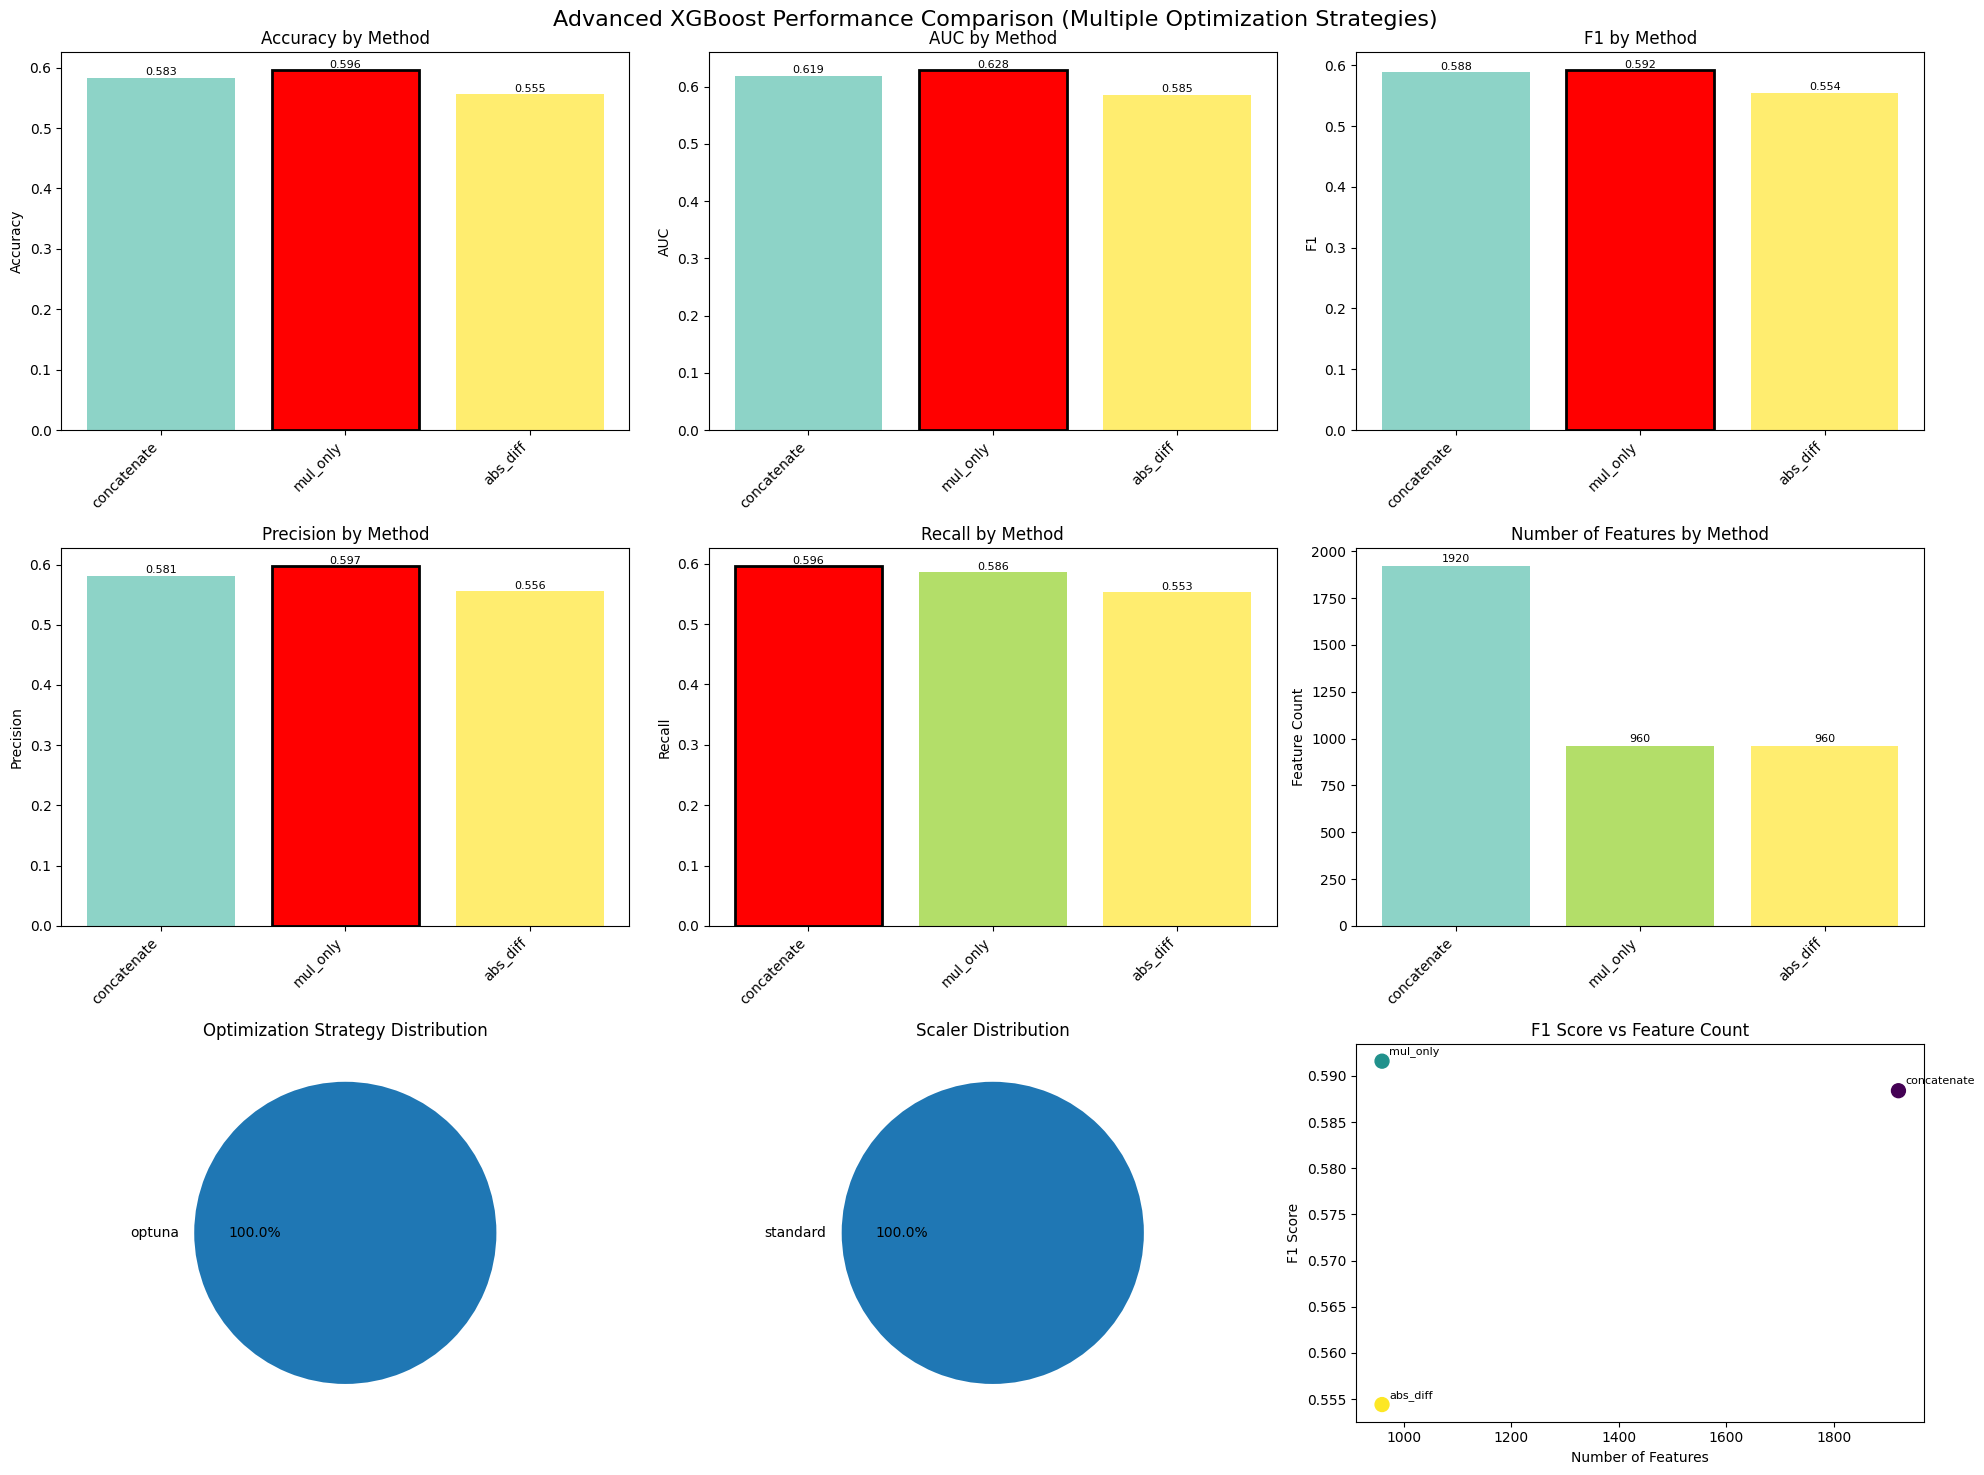


OPTIMIZATION DETAILS FOR BEST METHOD: MUL_ONLY

OPTUNA Results:
  Score: 0.5916
  Best parameters:
    n_estimators: 294
    learning_rate: 0.05669796065463295
    max_depth: 4
    min_child_weight: 5
    subsample: 0.8505915654206465
    colsample_bytree: 0.774439933428912
    gamma: 2.5338812843583347
    reg_alpha: 5.4034968583244485
    reg_lambda: 6.915251810530524
    verbosity: 0


In [6]:
# Create comprehensive comparison and visualization
if results:
    print("="*120)
    print("COMPREHENSIVE COMPARISON OF ALL FEATURE COMBINATION METHODS (ADVANCED TUNING)")
    print("="*120)

    # Create detailed comparison dataframe
    comparison_data = []
    for method, result in results.items():
        comparison_data.append({
            'Method': method,
            'Scaler': result['scaler_type'],
            'Optimization': result['optimization_strategy'],
            'Accuracy': result['accuracy'],
            'AUC': result['auc'],
            'F1': result['f1'],
            'Precision': result['precision'],
            'Recall': result['recall'],
            'Features': result['X_train_scaled'].shape[1]
        })

    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.round(4)
    print(comparison_df.to_string(index=False))

    # Advanced visualization
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    fig.suptitle('Advanced XGBoost Performance Comparison (Multiple Optimization Strategies)', fontsize=16)

    metrics = ['Accuracy', 'AUC', 'F1', 'Precision', 'Recall']
    colors = plt.cm.Set3(np.linspace(0, 1, len(comparison_df)))
    
    # Performance metrics plots
    for i, metric in enumerate(metrics):
        row, col = i // 3, i % 3
        ax = axes[row, col]
        
        bars = ax.bar(range(len(comparison_df)), comparison_df[metric], color=colors)
        ax.set_title(f'{metric} by Method')
        ax.set_ylabel(metric)
        ax.set_xticks(range(len(comparison_df)))
        ax.set_xticklabels(comparison_df['Method'], rotation=45, ha='right')
        
        # Highlight the best method
        best_idx = comparison_df[metric].idxmax()
        bars[best_idx].set_color('red')
        bars[best_idx].set_edgecolor('black')
        bars[best_idx].set_linewidth(2)
        
        # Add value labels on bars
        for j, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=8)

    # Feature count comparison
    ax = axes[1, 2]
    bars = ax.bar(range(len(comparison_df)), comparison_df['Features'], color=colors)
    ax.set_title('Number of Features by Method')
    ax.set_ylabel('Feature Count')
    ax.set_xticks(range(len(comparison_df)))
    ax.set_xticklabels(comparison_df['Method'], rotation=45, ha='right')
    
    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 10,
                f'{int(height)}', ha='center', va='bottom', fontsize=8)

    # Optimization strategy distribution
    ax = axes[2, 0]
    strategy_counts = comparison_df['Optimization'].value_counts()
    ax.pie(strategy_counts.values, labels=strategy_counts.index, autopct='%1.1f%%')
    ax.set_title('Optimization Strategy Distribution')

    # Scaler distribution
    ax = axes[2, 1]
    scaler_counts = comparison_df['Scaler'].value_counts()
    ax.pie(scaler_counts.values, labels=scaler_counts.index, autopct='%1.1f%%')
    ax.set_title('Scaler Distribution')

    # Performance vs Features scatter plot
    ax = axes[2, 2]
    scatter = ax.scatter(comparison_df['Features'], comparison_df['F1'], 
                        c=range(len(comparison_df)), cmap='viridis', s=100)
    ax.set_xlabel('Number of Features')
    ax.set_ylabel('F1 Score')
    ax.set_title('F1 Score vs Feature Count')
    
    # Add method labels to scatter points
    for i, method in enumerate(comparison_df['Method']):
        ax.annotate(method, (comparison_df.iloc[i]['Features'], comparison_df.iloc[i]['F1']),
                   xytext=(5, 5), textcoords='offset points', fontsize=8)

    plt.tight_layout()
    plt.show()

    # Show optimization details for best method
    if best_overall_method in results:
        print(f"\n{'='*80}")
        print(f"OPTIMIZATION DETAILS FOR BEST METHOD: {best_overall_method.upper()}")
        print(f"{'='*80}")
        
        opt_results = results[best_overall_method]['optimization_results']
        for strategy, result in opt_results.items():
            print(f"\n{strategy.upper()} Results:")
            print(f"  Score: {result['score']:.4f}")
            print(f"  Best parameters:")
            for param, value in result['params'].items():
                if param not in ['tree_method', 'random_state', 'eval_metric', 'n_jobs']:
                    print(f"    {param}: {value}")

else:
    print("No successful results to display.")